# 가상환경에서 진행예정.

env_name = detectron2_py3.8 <br/>
---
- version : <br/>
    - torch 1.8 <br/>
    - cuda 10.2 <br/>
    - python 3.8.16 <br/>

## index
0 = person ------------------------<br/>
1 = bicycle ----------------------------<br/>
2 = car ----------------------------<br/>
3 = motorcycle ----------------------<br/>
~~4 = airplane~~<br/>
5 = bus --------------------------------<br/>
~~6 = train ~~<br/>
7 = truck --------------------------------<br/>

# IMAGE

In [12]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import torch
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from collections import deque
import multiprocessing as mp
import atexit
import bisect
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
import time

import predictor
from demo import VisualizationDemo

In [13]:
from detectron2.structures import Boxes

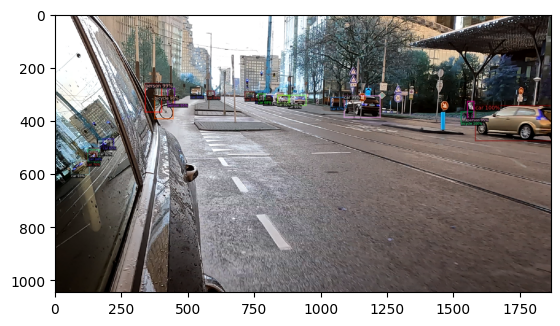

In [14]:
input_image_path = '/home/sldev1/github/data/test1.png'

oim = cv2.imread(input_image_path)
#print('original image')
#cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.MODEL.DEVICE = 'cpu' #changing to cpu
predictor = DefaultPredictor(cfg)

## Function for detecting and segmenting only 1 class i.e cups
def onlykeep_person_class(outputs):
    cls = outputs['instances'].pred_classes
    scores = outputs["instances"].scores
    boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>
        
    a = (cls == 0).nonzero().flatten().tolist()
    b = (cls == 1).nonzero().flatten().tolist()
    c = (cls == 2).nonzero().flatten().tolist()
    d = (cls == 3).nonzero().flatten().tolist()
    e = (cls == 5).nonzero().flatten().tolist()
    f = (cls == 7).nonzero().flatten().tolist()

    a.extend(b)
    a.extend(c)
    a.extend(d)
    a.extend(e)
    a.extend(f)
    
    a.sort()

    indx_to_keep = a
    
  # only keeping index  corresponding arrays
    cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
    scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
    boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
  # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(oim.shape[0], oim.shape[1]))
    obj.set('pred_classes', cls1)
    obj.set('scores', scores1)
    obj.set('pred_boxes',boxes1)
    
    return obj

### predictions and only cup detection display
original_outputs = predictor(oim) #30 seconds(CPU) #1 seconds(GPU)
modified_outputs = onlykeep_person_class(original_outputs)


v = Visualizer(oim[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(modified_outputs.to("cpu"))
cv2.imwrite(input_image_path.replace(".","_only_6classes_detected."),out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1])

In [78]:
  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>

person_count = (original_outputs['instances'].pred_classes).tolist().count(0)
bicycle_count = (original_outputs['instances'].pred_classes).tolist().count(1)
car_count = (original_outputs['instances'].pred_classes).tolist().count(2)
motorcycle_count = (original_outputs['instances'].pred_classes).tolist().count(3)
bus_count = (original_outputs['instances'].pred_classes).tolist().count(5)
truck_count = (original_outputs['instances'].pred_classes).tolist().count(7)

print(f" person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle_count : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")

 person : 3 
 bicycle : 2 
 car : 17 
 motorcycle_count : 0 
 bus : 0 
 truck : 0


In [62]:
a = (original_outputs['instances'].pred_classes == 0).nonzero().flatten().tolist().

# b = (original_outputs['instances'].pred_classes == 1).nonzero().flatten().tolist()
# c = (original_outputs['instances'].pred_classes == 2).nonzero().flatten().tolist()
# d = (original_outputs['instances'].pred_classes == 3).nonzero().flatten().tolist()
# e = (original_outputs['instances'].pred_classes == 5).nonzero().flatten().tolist()
# f = (original_outputs['instances'].pred_classes == 7).nonzero().flatten().tolist()

# a.extend(b)
# a.extend(c)
# a.extend(d)
# a.extend(e)
# a.extend(f)

# a.sort()
a

[2, 6, 7]

# 뜯어보는 중

In [17]:
# 0 1 2 3 5 7

# cls == 0
x = original_outputs['instances'].pred_classes
wanted_x = onlykeep_person_class(x)

print(wanted_x, "\n\n")


a = (x == 0).nonzero().flatten().tolist()
b = (x == 1).nonzero().flatten().tolist()
c = (x == 2).nonzero().flatten().tolist()
d = (x == 3).nonzero().flatten().tolist()
e = (x == 5).nonzero().flatten().tolist()
f = (x == 7).nonzero().flatten().tolist()
a.extend(b)
a.extend(c)
a.extend(d)
a.extend(e)
a.extend(f)
a.sort()


print(a,"\n\n", b,"\n\n",c, "\n\n")


(x == 0).nonzero().flatten().tolist()

IndexError: too many indices for tensor of dimension 1

# VIDEO
참고사이트
https://stackoverflow.com/questions/60663073/how-can-i-properly-run-detectron2-on-videos

In [4]:
#!/usr/bin/env python3
# -- coding: utf-8 --

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import torch
import numpy as np
import tqdm
import cv2
import glob
import re
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import Boxes
import time

In [5]:
path = "/home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/"

def videoPath(path):
    video_path = glob.glob(path+'*.MP4')

    return video_path

video_list = videoPath(path)

In [6]:
def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """
    def onlykeep_wanted_class(outputs):
        cls = outputs['instances'].pred_classes
        scores = outputs["instances"].scores
        boxes = outputs['instances'].pred_boxes

      # index to keep whose class == 0
            # index chart
            # 0 = person -------------------------<br/>
            # 1 = bicycle ------------------------<br/>
            # 2 = car ----------------------------<br/>
            # 3 = motorcycle ---------------------<br/>
            # 4 = airplane
            # 5 = bus -----------------------------<br/>
            # 6 = train
            # 7 = truck ---------------------------<br/>

        a = (cls == 0).nonzero().flatten().tolist()
        b = (cls == 1).nonzero().flatten().tolist()
        c = (cls == 2).nonzero().flatten().tolist()
        d = (cls == 3).nonzero().flatten().tolist()
        e = (cls == 5).nonzero().flatten().tolist()
        f = (cls == 7).nonzero().flatten().tolist()

        a.extend(b)
        a.extend(c)
        a.extend(d)
        a.extend(e)
        a.extend(f)

        a.sort()

        indx_to_keep = a

      # only keeping index  corresponding arrays
        cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
        scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
        boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))

      # create new instance obj and set its fields
        obj = detectron2.structures.Instances(image_size=(frame.shape[0], frame.shape[1]))
        obj.set('pred_classes', cls1)
        obj.set('scores', scores1)
        obj.set('pred_boxes',boxes1)

        return obj

    readFrames = 0

    
    
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame) # original_output
        
        global person_count
        global bicycle_count
        global car_count
        global motorcycle_count
        global bus_count
        global truck_count
        person_count += (outputs['instances'].pred_classes).tolist().count(0)
        bicycle_count += (outputs['instances'].pred_classes).tolist().count(1)
        car_count += (outputs['instances'].pred_classes).tolist().count(2)
        motorcycle_count += (outputs['instances'].pred_classes).tolist().count(3)
        bus_count += (outputs['instances'].pred_classes).tolist().count(5)
        truck_count += (outputs['instances'].pred_classes).tolist().count(7)

        #print(f" person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle_count : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")


        
        wanted_outputs = onlykeep_wanted_class(outputs)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, wanted_outputs.to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield visualization

        readFrames += 1
        if readFrames > maxFrames:
            break

In [ ]:
for i in tqdm.tqdm(video_list):

    # Extract video properties
    print("***************************\n", i, "\n*****************************")
    video = cv2.VideoCapture(i)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"width : {width}, height : {height}, frames_per_second : {frames_per_second}, num_frames : {num_frames}")

    # Initialize video writer
    video_writer = cv2.VideoWriter(i[:-4]+"_output.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

    # Initialize predictor
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)

    # Initialize visualizer
    v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)

    person_count = 0
    bicycle_count = 0
    car_count = 0
    motorcycle_count = 0
    bus_count = 0
    truck_count = 0




    # Create a cut-off for debugging
#     num_frames = 30

    # Enumerate the frames of the video
    for visualization in tqdm.tqdm(runOnVideo(video, num_frames)):

        # Write test image
        cv2.imwrite(i[:-4]+'_output.png', visualization)

        # Write to video file
        video_writer.write(visualization)

    # print total count of classes
    print(f" {i}의 제원***********\n person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")
    
    details1 = [(f"\n\n\n {i}의 제원***********\n person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")]
    details2 = [(f"width : {width}, height : {height}, frames_per_second : {frames_per_second}, num_frames : {num_frames}")]
    
    with open('readme.txt', 'a') as f:
        f.write('\n'.join(details1))
        f.write('\n'.join(details2))
    
    # Release resources
    video.release()
    video_writer.release()
    cv2.destroyAllWindows()
    
    #LH 걸린 시간 : 75:32:56

  0%|                                                                                             | 0/23 [00:00<?, ?it/s]

***************************
 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_4_1.MP4 
*****************************
width : 3840, height : 2160, frames_per_second : 29.97002997002997, num_frames : 15990



0it [00:00, ?it/s]
1it [00:01,  1.08s/it]
2it [00:01,  1.03it/s]
3it [00:02,  1.08it/s]
4it [00:03,  1.12it/s]
5it [00:04,  1.13it/s]
6it [00:05,  1.14it/s]
7it [00:06,  1.14it/s]
8it [00:07,  1.15it/s]
9it [00:08,  1.15it/s]
10it [00:08,  1.15it/s]
11it [00:09,  1.16it/s]
12it [00:10,  1.15it/s]
13it [00:11,  1.14it/s]
14it [00:12,  1.14it/s]
15it [00:13,  1.15it/s]
16it [00:14,  1.13it/s]
17it [00:15,  1.13it/s]
18it [00:15,  1.14it/s]
19it [00:16,  1.15it/s]
20it [00:17,  1.14it/s]
21it [00:18,  1.15it/s]
22it [00:19,  1.14it/s]
23it [00:20,  1.14it/s]
24it [00:21,  1.13it/s]
25it [00:22,  1.15it/s]
26it [00:22,  1.13it/s]
27it [00:23,  1.13it/s]
28it [00:24,  1.14it/s]
29it [00:25,  1.13it/s]
30it [00:26,  1.13it/s]
31it [00:27,  1.13it/s]
32it [00:28,  1.14it/s]
33it [00:29,  1.13it/s]
34it [00:30,  1.13it/s]
35it [00:30,  1.14it/s]
36it [00:31,  1.13it/s]
37it [00:32,  1.12it/s]
38it [00:33,  1.11it/s]
39it [00:34,  1.12it/s]
40it [00:35,  1.12it/s]
41it [00:36,  1.12it/s]
42it 

296it [04:34,  1.08it/s]
297it [04:35,  1.08it/s]
298it [04:36,  1.08it/s]
299it [04:37,  1.08it/s]
300it [04:37,  1.09it/s]
301it [04:38,  1.10it/s]
302it [04:39,  1.10it/s]
303it [04:40,  1.10it/s]
304it [04:41,  1.10it/s]
305it [04:42,  1.09it/s]
306it [04:43,  1.09it/s]
307it [04:44,  1.08it/s]
308it [04:45,  1.08it/s]
309it [04:46,  1.08it/s]
310it [04:47,  1.07it/s]
311it [04:48,  1.07it/s]
312it [04:49,  1.07it/s]
313it [04:50,  1.07it/s]
314it [04:50,  1.07it/s]
315it [04:51,  1.07it/s]
316it [04:52,  1.08it/s]
317it [04:53,  1.08it/s]
318it [04:54,  1.08it/s]
319it [04:55,  1.08it/s]
320it [04:56,  1.08it/s]
321it [04:57,  1.08it/s]
322it [04:58,  1.08it/s]
323it [04:59,  1.08it/s]
324it [05:00,  1.08it/s]
325it [05:01,  1.08it/s]
326it [05:02,  1.08it/s]
327it [05:02,  1.08it/s]
328it [05:03,  1.08it/s]
329it [05:04,  1.08it/s]
330it [05:05,  1.08it/s]
331it [05:06,  1.08it/s]
332it [05:07,  1.09it/s]
333it [05:08,  1.08it/s]
334it [05:09,  1.07it/s]
335it [05:10,  1.08it/s]


588it [09:05,  1.10it/s]
589it [09:06,  1.10it/s]
590it [09:07,  1.10it/s]
591it [09:08,  1.10it/s]
592it [09:09,  1.10it/s]
593it [09:10,  1.10it/s]
594it [09:11,  1.10it/s]
595it [09:12,  1.10it/s]
596it [09:13,  1.10it/s]
597it [09:13,  1.10it/s]
598it [09:14,  1.10it/s]
599it [09:15,  1.10it/s]
600it [09:16,  1.10it/s]
601it [09:17,  1.11it/s]
602it [09:18,  1.11it/s]
603it [09:19,  1.11it/s]
604it [09:20,  1.11it/s]
605it [09:21,  1.11it/s]
606it [09:22,  1.09it/s]
607it [09:23,  1.07it/s]
608it [09:24,  1.08it/s]
609it [09:25,  1.07it/s]
610it [09:25,  1.08it/s]
611it [09:26,  1.08it/s]
612it [09:27,  1.08it/s]
613it [09:28,  1.07it/s]
614it [09:29,  1.08it/s]
615it [09:30,  1.07it/s]
616it [09:31,  1.07it/s]
617it [09:32,  1.08it/s]
618it [09:33,  1.08it/s]
619it [09:34,  1.07it/s]
620it [09:35,  1.07it/s]
621it [09:36,  1.07it/s]
622it [09:37,  1.06it/s]
623it [09:38,  1.07it/s]
624it [09:38,  1.08it/s]
625it [09:39,  1.08it/s]
626it [09:40,  1.07it/s]
627it [09:41,  1.07it/s]


880it [13:44,  1.01it/s]
881it [13:45,  1.00s/it]
882it [13:46,  1.01it/s]
883it [13:47,  1.02it/s]
884it [13:48,  1.03it/s]
885it [13:49,  1.03it/s]
886it [13:50,  1.03it/s]
887it [13:51,  1.04it/s]
888it [13:52,  1.03it/s]
889it [13:53,  1.03it/s]
890it [13:54,  1.03it/s]
891it [13:55,  1.04it/s]
892it [13:56,  1.04it/s]
893it [13:57,  1.05it/s]
894it [13:58,  1.05it/s]
895it [13:59,  1.05it/s]
896it [14:00,  1.05it/s]
897it [14:00,  1.06it/s]
898it [14:01,  1.06it/s]
899it [14:02,  1.05it/s]
900it [14:03,  1.04it/s]
901it [14:04,  1.05it/s]
902it [14:05,  1.05it/s]
903it [14:06,  1.03it/s]
904it [14:07,  1.03it/s]
905it [14:08,  1.02it/s]
906it [14:09,  1.03it/s]
907it [14:10,  1.02it/s]
908it [14:11,  1.03it/s]
909it [14:12,  1.02it/s]
910it [14:13,  1.04it/s]
911it [14:14,  1.05it/s]
912it [14:15,  1.06it/s]
913it [14:16,  1.06it/s]
914it [14:17,  1.07it/s]
915it [14:18,  1.07it/s]
916it [14:19,  1.07it/s]
917it [14:20,  1.07it/s]
918it [14:20,  1.07it/s]
919it [14:21,  1.07it/s]


1166it [18:37,  1.05it/s]
1167it [18:38,  1.05it/s]
1168it [18:38,  1.06it/s]
1169it [18:39,  1.05it/s]
1170it [18:40,  1.05it/s]
1171it [18:41,  1.05it/s]
1172it [18:42,  1.05it/s]
1173it [18:43,  1.05it/s]
1174it [18:44,  1.05it/s]
1175it [18:45,  1.05it/s]
1176it [18:46,  1.05it/s]
1177it [18:47,  1.05it/s]
1178it [18:48,  1.05it/s]
1179it [18:49,  1.05it/s]
1180it [18:50,  1.04it/s]
1181it [18:51,  1.04it/s]
1182it [18:52,  1.05it/s]
1183it [18:53,  1.04it/s]
1184it [18:54,  1.04it/s]
1185it [18:55,  1.03it/s]
1186it [18:56,  1.03it/s]
1187it [18:57,  1.02it/s]
1188it [18:58,  1.02it/s]
1189it [18:59,  1.02it/s]
1190it [19:00,  1.03it/s]
1191it [19:01,  1.04it/s]
1192it [19:02,  1.03it/s]
1193it [19:03,  1.04it/s]
1194it [19:04,  1.04it/s]
1195it [19:04,  1.03it/s]
1196it [19:05,  1.03it/s]
1197it [19:06,  1.02it/s]
1198it [19:07,  1.02it/s]
1199it [19:08,  1.02it/s]
1200it [19:09,  1.01it/s]
1201it [19:10,  1.01it/s]
1202it [19:11,  1.01it/s]
1203it [19:12,  1.00it/s]
1204it [19:1

1448it [23:09,  1.01it/s]
1449it [23:10,  1.01it/s]
1450it [23:11,  1.01it/s]
1451it [23:12,  1.02it/s]
1452it [23:13,  1.02it/s]
1453it [23:14,  1.02it/s]
1454it [23:15,  1.02it/s]
1455it [23:16,  1.02it/s]
1456it [23:17,  1.02it/s]
1457it [23:18,  1.03it/s]
1458it [23:19,  1.02it/s]
1459it [23:20,  1.03it/s]
1460it [23:21,  1.03it/s]
1461it [23:22,  1.03it/s]
1462it [23:23,  1.04it/s]
1463it [23:23,  1.04it/s]
1464it [23:24,  1.04it/s]
1465it [23:25,  1.04it/s]
1466it [23:26,  1.04it/s]
1467it [23:27,  1.04it/s]
1468it [23:28,  1.04it/s]
1469it [23:29,  1.02it/s]
1470it [23:30,  1.03it/s]
1471it [23:31,  1.02it/s]
1472it [23:32,  1.04it/s]
1473it [23:33,  1.05it/s]
1474it [23:34,  1.06it/s]
1475it [23:35,  1.07it/s]
1476it [23:36,  1.06it/s]
1477it [23:37,  1.06it/s]
1478it [23:38,  1.05it/s]
1479it [23:39,  1.05it/s]
1480it [23:40,  1.04it/s]
1481it [23:41,  1.04it/s]
1482it [23:42,  1.03it/s]
1483it [23:43,  1.03it/s]
1484it [23:44,  1.03it/s]
1485it [23:45,  1.04it/s]
1486it [23:4

1730it [27:31,  1.11it/s]
1731it [27:32,  1.10it/s]
1732it [27:32,  1.10it/s]
1733it [27:33,  1.11it/s]
1734it [27:34,  1.10it/s]
1735it [27:35,  1.10it/s]
1736it [27:36,  1.11it/s]
1737it [27:37,  1.11it/s]
1738it [27:38,  1.10it/s]
1739it [27:39,  1.09it/s]
1740it [27:40,  1.10it/s]
1741it [27:41,  1.09it/s]
1742it [27:42,  1.08it/s]
1743it [27:42,  1.09it/s]
1744it [27:43,  1.07it/s]
1745it [27:44,  1.07it/s]
1746it [27:45,  1.08it/s]
1747it [27:46,  1.09it/s]
1748it [27:47,  1.08it/s]
1749it [27:48,  1.08it/s]
1750it [27:49,  1.10it/s]
1751it [27:50,  1.09it/s]
1752it [27:51,  1.09it/s]
1753it [27:52,  1.09it/s]
1754it [27:53,  1.10it/s]
1755it [27:54,  1.09it/s]
1756it [27:54,  1.09it/s]
1757it [27:55,  1.08it/s]
1758it [27:56,  1.09it/s]
1759it [27:57,  1.08it/s]
1760it [27:58,  1.08it/s]
1761it [27:59,  1.09it/s]
1762it [28:00,  1.08it/s]
1763it [28:01,  1.08it/s]
1764it [28:02,  1.08it/s]
1765it [28:03,  1.09it/s]
1766it [28:04,  1.08it/s]
1767it [28:05,  1.07it/s]
1768it [28:0

2012it [31:48,  1.08it/s]
2013it [31:49,  1.08it/s]
2014it [31:50,  1.07it/s]
2015it [31:51,  1.07it/s]
2016it [31:51,  1.08it/s]
2017it [31:52,  1.08it/s]
2018it [31:53,  1.08it/s]
2019it [31:54,  1.08it/s]
2020it [31:55,  1.08it/s]
2021it [31:56,  1.09it/s]
2022it [31:57,  1.09it/s]
2023it [31:58,  1.08it/s]
2024it [31:59,  1.06it/s]
2025it [32:00,  1.07it/s]
2026it [32:01,  1.07it/s]
2027it [32:02,  1.08it/s]
2028it [32:03,  1.08it/s]
2029it [32:04,  1.09it/s]
2030it [32:04,  1.09it/s]
2031it [32:05,  1.09it/s]
2032it [32:06,  1.09it/s]
2033it [32:07,  1.09it/s]
2034it [32:08,  1.09it/s]
2035it [32:09,  1.09it/s]
2036it [32:10,  1.09it/s]
2037it [32:11,  1.09it/s]
2038it [32:12,  1.08it/s]
2039it [32:13,  1.08it/s]
2040it [32:14,  1.08it/s]
2041it [32:15,  1.08it/s]
2042it [32:16,  1.07it/s]
2043it [32:16,  1.07it/s]
2044it [32:17,  1.07it/s]
2045it [32:18,  1.07it/s]
2046it [32:19,  1.07it/s]
2047it [32:20,  1.08it/s]
2048it [32:21,  1.07it/s]
2049it [32:22,  1.08it/s]
2050it [32:2

2294it [36:14,  1.02it/s]
2295it [36:15,  1.02it/s]
2296it [36:16,  1.02it/s]
2297it [36:17,  1.02it/s]
2298it [36:18,  1.02it/s]
2299it [36:18,  1.02it/s]
2300it [36:19,  1.01it/s]
2301it [36:20,  1.03it/s]
2302it [36:21,  1.04it/s]
2303it [36:22,  1.05it/s]
2304it [36:23,  1.05it/s]
2305it [36:24,  1.06it/s]
2306it [36:25,  1.06it/s]
2307it [36:26,  1.06it/s]
2308it [36:27,  1.07it/s]
2309it [36:28,  1.07it/s]
2310it [36:29,  1.07it/s]
2311it [36:30,  1.07it/s]
2312it [36:31,  1.07it/s]
2313it [36:32,  1.07it/s]
2314it [36:33,  1.07it/s]
2315it [36:34,  1.07it/s]
2316it [36:34,  1.07it/s]
2317it [36:35,  1.07it/s]
2318it [36:36,  1.07it/s]
2319it [36:37,  1.06it/s]
2320it [36:38,  1.07it/s]
2321it [36:39,  1.07it/s]
2322it [36:40,  1.07it/s]
2323it [36:41,  1.05it/s]
2324it [36:42,  1.06it/s]
2325it [36:43,  1.07it/s]
2326it [36:44,  1.07it/s]
2327it [36:45,  1.07it/s]
2328it [36:46,  1.07it/s]
2329it [36:47,  1.08it/s]
2330it [36:48,  1.08it/s]
2331it [36:48,  1.08it/s]
2332it [36:4

2576it [40:37,  1.04it/s]
2577it [40:38,  1.05it/s]
2578it [40:39,  1.05it/s]
2579it [40:39,  1.06it/s]
2580it [40:40,  1.04it/s]
2581it [40:41,  1.06it/s]
2582it [40:42,  1.08it/s]
2583it [40:43,  1.08it/s]
2584it [40:44,  1.08it/s]
2585it [40:45,  1.08it/s]
2586it [40:46,  1.08it/s]
2587it [40:47,  1.08it/s]
2588it [40:48,  1.07it/s]
2589it [40:49,  1.06it/s]
2590it [40:50,  1.07it/s]
2591it [40:51,  1.06it/s]
2592it [40:52,  1.05it/s]
2593it [40:53,  1.05it/s]
2594it [40:54,  1.05it/s]
2595it [40:54,  1.06it/s]
2596it [40:55,  1.06it/s]
2597it [40:56,  1.06it/s]
2598it [40:57,  1.06it/s]
2599it [40:58,  1.06it/s]
2600it [40:59,  1.06it/s]
2601it [41:00,  1.06it/s]
2602it [41:01,  1.06it/s]
2603it [41:02,  1.05it/s]
2604it [41:03,  1.06it/s]
2605it [41:04,  1.06it/s]
2606it [41:05,  1.06it/s]
2607it [41:06,  1.06it/s]
2608it [41:07,  1.05it/s]
2609it [41:08,  1.05it/s]
2610it [41:09,  1.05it/s]
2611it [41:10,  1.05it/s]
2612it [41:11,  1.06it/s]
2613it [41:11,  1.06it/s]
2614it [41:1

2858it [45:02,  1.07it/s]
2859it [45:03,  1.06it/s]
2860it [45:04,  1.06it/s]
2861it [45:05,  1.07it/s]
2862it [45:06,  1.07it/s]
2863it [45:07,  1.07it/s]
2864it [45:08,  1.08it/s]
2865it [45:09,  1.08it/s]
2866it [45:09,  1.08it/s]
2867it [45:10,  1.09it/s]
2868it [45:11,  1.09it/s]
2869it [45:12,  1.09it/s]
2870it [45:13,  1.09it/s]
2871it [45:14,  1.08it/s]
2872it [45:15,  1.07it/s]
2873it [45:16,  1.08it/s]
2874it [45:17,  1.08it/s]
2875it [45:18,  1.07it/s]
2876it [45:19,  1.06it/s]
2877it [45:20,  1.06it/s]
2878it [45:21,  1.05it/s]
2879it [45:22,  1.04it/s]
2880it [45:23,  1.04it/s]
2881it [45:24,  1.05it/s]
2882it [45:25,  1.04it/s]
2883it [45:25,  1.05it/s]
2884it [45:26,  1.04it/s]
2885it [45:27,  1.06it/s]
2886it [45:28,  1.07it/s]
2887it [45:29,  1.08it/s]
2888it [45:30,  1.09it/s]
2889it [45:31,  1.10it/s]
2890it [45:32,  1.11it/s]
2891it [45:33,  1.11it/s]
2892it [45:34,  1.12it/s]
2893it [45:34,  1.13it/s]
2894it [45:35,  1.13it/s]
2895it [45:36,  1.13it/s]
2896it [45:3

3140it [49:20,  1.09it/s]
3141it [49:21,  1.08it/s]
3142it [49:22,  1.06it/s]
3143it [49:23,  1.08it/s]
3144it [49:24,  1.08it/s]
3145it [49:25,  1.09it/s]
3146it [49:26,  1.10it/s]
3147it [49:27,  1.10it/s]
3148it [49:28,  1.10it/s]
3149it [49:29,  1.10it/s]
3150it [49:30,  1.11it/s]
3151it [49:31,  1.11it/s]
3152it [49:31,  1.11it/s]
3153it [49:32,  1.12it/s]
3154it [49:33,  1.12it/s]
3155it [49:34,  1.12it/s]
3156it [49:35,  1.13it/s]
3157it [49:36,  1.13it/s]
3158it [49:37,  1.13it/s]
3159it [49:38,  1.12it/s]
3160it [49:39,  1.11it/s]
3161it [49:39,  1.11it/s]
3162it [49:40,  1.11it/s]
3163it [49:41,  1.11it/s]
3164it [49:42,  1.12it/s]
3165it [49:43,  1.12it/s]
3166it [49:44,  1.12it/s]
3167it [49:45,  1.12it/s]
3168it [49:46,  1.12it/s]
3169it [49:47,  1.13it/s]
3170it [49:47,  1.12it/s]
3171it [49:48,  1.12it/s]
3172it [49:49,  1.12it/s]
3173it [49:50,  1.12it/s]
3174it [49:51,  1.12it/s]
3175it [49:52,  1.12it/s]
3176it [49:53,  1.12it/s]
3177it [49:54,  1.12it/s]
3178it [49:5

3422it [53:39,  1.08it/s]
3423it [53:40,  1.09it/s]
3424it [53:41,  1.09it/s]
3425it [53:42,  1.08it/s]
3426it [53:43,  1.10it/s]
3427it [53:44,  1.09it/s]
3428it [53:45,  1.09it/s]
3429it [53:46,  1.09it/s]
3430it [53:47,  1.09it/s]
3431it [53:47,  1.09it/s]
3432it [53:48,  1.10it/s]
3433it [53:49,  1.09it/s]
3434it [53:50,  1.09it/s]
3435it [53:51,  1.09it/s]
3436it [53:52,  1.08it/s]
3437it [53:53,  1.08it/s]
3438it [53:54,  1.09it/s]
3439it [53:55,  1.09it/s]
3440it [53:56,  1.08it/s]
3441it [53:57,  1.08it/s]
3442it [53:58,  1.10it/s]
3443it [53:58,  1.09it/s]
3444it [53:59,  1.09it/s]
3445it [54:00,  1.10it/s]
3446it [54:01,  1.09it/s]
3447it [54:02,  1.09it/s]
3448it [54:03,  1.10it/s]
3449it [54:04,  1.10it/s]
3450it [54:05,  1.10it/s]
3451it [54:06,  1.09it/s]
3452it [54:07,  1.11it/s]
3453it [54:08,  1.10it/s]
3454it [54:08,  1.10it/s]
3455it [54:09,  1.11it/s]
3456it [54:10,  1.10it/s]
3457it [54:11,  1.09it/s]
3458it [54:12,  1.10it/s]
3459it [54:13,  1.09it/s]
3460it [54:1

3704it [57:58,  1.09it/s]
3705it [57:59,  1.08it/s]
3706it [58:00,  1.08it/s]
3707it [58:01,  1.08it/s]
3708it [58:02,  1.08it/s]
3709it [58:03,  1.08it/s]
3710it [58:04,  1.09it/s]
3711it [58:05,  1.08it/s]
3712it [58:05,  1.07it/s]
3713it [58:06,  1.06it/s]
3714it [58:07,  1.07it/s]
3715it [58:08,  1.06it/s]
3716it [58:09,  1.06it/s]
3717it [58:10,  1.06it/s]
3718it [58:11,  1.04it/s]
3719it [58:12,  1.04it/s]
3720it [58:13,  1.01it/s]
3721it [58:14,  1.04it/s]
3722it [58:15,  1.05it/s]
3723it [58:16,  1.07it/s]
3724it [58:17,  1.07it/s]
3725it [58:18,  1.07it/s]
3726it [58:19,  1.08it/s]
3727it [58:20,  1.07it/s]
3728it [58:21,  1.06it/s]
3729it [58:22,  1.07it/s]
3730it [58:22,  1.07it/s]
3731it [58:23,  1.06it/s]
3732it [58:24,  1.05it/s]
3733it [58:25,  1.08it/s]
3734it [58:26,  1.09it/s]
3735it [58:27,  1.10it/s]
3736it [58:28,  1.10it/s]
3737it [58:29,  1.11it/s]
3738it [58:30,  1.11it/s]
3739it [58:31,  1.12it/s]
3740it [58:32,  1.12it/s]
3741it [58:32,  1.12it/s]
3742it [58:3

3976it [1:02:09,  1.07it/s]
3977it [1:02:10,  1.08it/s]
3978it [1:02:11,  1.09it/s]
3979it [1:02:11,  1.10it/s]
3980it [1:02:12,  1.10it/s]
3981it [1:02:13,  1.10it/s]
3982it [1:02:14,  1.10it/s]
3983it [1:02:15,  1.10it/s]
3984it [1:02:16,  1.10it/s]
3985it [1:02:17,  1.10it/s]
3986it [1:02:18,  1.09it/s]
3987it [1:02:19,  1.09it/s]
3988it [1:02:20,  1.08it/s]
3989it [1:02:21,  1.09it/s]
3990it [1:02:22,  1.08it/s]
3991it [1:02:22,  1.08it/s]
3992it [1:02:23,  1.09it/s]
3993it [1:02:24,  1.08it/s]
3994it [1:02:25,  1.09it/s]
3995it [1:02:26,  1.09it/s]
3996it [1:02:27,  1.09it/s]
3997it [1:02:28,  1.10it/s]
3998it [1:02:29,  1.09it/s]
3999it [1:02:30,  1.09it/s]
4000it [1:02:31,  1.09it/s]
4001it [1:02:32,  1.08it/s]
4002it [1:02:33,  1.07it/s]
4003it [1:02:34,  1.07it/s]
4004it [1:02:34,  1.06it/s]
4005it [1:02:35,  1.06it/s]
4006it [1:02:36,  1.05it/s]
4007it [1:02:37,  1.05it/s]
4008it [1:02:38,  1.04it/s]
4009it [1:02:39,  1.06it/s]
4010it [1:02:40,  1.07it/s]
4011it [1:02:41,  1.

4240it [1:06:14,  1.05it/s]
4241it [1:06:15,  1.05it/s]
4242it [1:06:16,  1.04it/s]
4243it [1:06:17,  1.06it/s]
4244it [1:06:18,  1.06it/s]
4245it [1:06:19,  1.07it/s]
4246it [1:06:20,  1.07it/s]
4247it [1:06:21,  1.08it/s]
4248it [1:06:22,  1.08it/s]
4249it [1:06:23,  1.09it/s]
4250it [1:06:24,  1.08it/s]
4251it [1:06:24,  1.08it/s]
4252it [1:06:25,  1.09it/s]
4253it [1:06:26,  1.08it/s]
4254it [1:06:27,  1.08it/s]
4255it [1:06:28,  1.08it/s]
4256it [1:06:29,  1.08it/s]
4257it [1:06:30,  1.08it/s]
4258it [1:06:31,  1.08it/s]
4259it [1:06:32,  1.08it/s]
4260it [1:06:33,  1.08it/s]
4261it [1:06:34,  1.08it/s]
4262it [1:06:35,  1.07it/s]
4263it [1:06:36,  1.07it/s]
4264it [1:06:37,  1.06it/s]
4265it [1:06:38,  1.05it/s]
4266it [1:06:38,  1.05it/s]
4267it [1:06:39,  1.04it/s]
4268it [1:06:40,  1.04it/s]
4269it [1:06:41,  1.05it/s]
4270it [1:06:42,  1.04it/s]
4271it [1:06:43,  1.04it/s]
4272it [1:06:44,  1.04it/s]
4273it [1:06:45,  1.03it/s]
4274it [1:06:46,  1.04it/s]
4275it [1:06:47,  1.

4504it [1:10:21,  1.10it/s]
4505it [1:10:22,  1.10it/s]
4506it [1:10:23,  1.10it/s]
4507it [1:10:24,  1.10it/s]
4508it [1:10:25,  1.10it/s]
4509it [1:10:26,  1.09it/s]
4510it [1:10:27,  1.09it/s]
4511it [1:10:28,  1.10it/s]
4512it [1:10:29,  1.10it/s]
4513it [1:10:30,  1.10it/s]
4514it [1:10:31,  1.10it/s]
4515it [1:10:31,  1.11it/s]
4516it [1:10:32,  1.10it/s]
4517it [1:10:33,  1.10it/s]
4518it [1:10:34,  1.10it/s]
4519it [1:10:35,  1.10it/s]
4520it [1:10:36,  1.09it/s]
4521it [1:10:37,  1.10it/s]
4522it [1:10:38,  1.10it/s]
4523it [1:10:39,  1.09it/s]
4524it [1:10:40,  1.09it/s]
4525it [1:10:41,  1.09it/s]
4526it [1:10:42,  1.08it/s]
4527it [1:10:43,  1.08it/s]
4528it [1:10:43,  1.08it/s]
4529it [1:10:44,  1.07it/s]
4530it [1:10:45,  1.08it/s]
4531it [1:10:46,  1.09it/s]
4532it [1:10:47,  1.08it/s]
4533it [1:10:48,  1.08it/s]
4534it [1:10:49,  1.09it/s]
4535it [1:10:50,  1.08it/s]
4536it [1:10:51,  1.07it/s]
4537it [1:10:52,  1.09it/s]
4538it [1:10:53,  1.08it/s]
4539it [1:10:54,  1.

4768it [1:14:24,  1.06it/s]
4769it [1:14:25,  1.06it/s]
4770it [1:14:26,  1.06it/s]
4771it [1:14:27,  1.05it/s]
4772it [1:14:28,  1.07it/s]
4773it [1:14:29,  1.07it/s]
4774it [1:14:30,  1.09it/s]
4775it [1:14:31,  1.10it/s]
4776it [1:14:32,  1.10it/s]
4777it [1:14:33,  1.10it/s]
4778it [1:14:34,  1.11it/s]
4779it [1:14:34,  1.11it/s]
4780it [1:14:35,  1.11it/s]
4781it [1:14:36,  1.11it/s]
4782it [1:14:37,  1.11it/s]
4783it [1:14:38,  1.11it/s]
4784it [1:14:39,  1.11it/s]
4785it [1:14:40,  1.11it/s]
4786it [1:14:41,  1.11it/s]
4787it [1:14:42,  1.10it/s]
4788it [1:14:43,  1.10it/s]
4789it [1:14:44,  1.11it/s]
4790it [1:14:44,  1.11it/s]
4791it [1:14:45,  1.11it/s]
4792it [1:14:46,  1.11it/s]
4793it [1:14:47,  1.10it/s]
4794it [1:14:48,  1.10it/s]
4795it [1:14:49,  1.10it/s]
4796it [1:14:50,  1.10it/s]
4797it [1:14:51,  1.10it/s]
4798it [1:14:52,  1.10it/s]
4799it [1:14:53,  1.09it/s]
4800it [1:14:54,  1.09it/s]
4801it [1:14:54,  1.09it/s]
4802it [1:14:55,  1.09it/s]
4803it [1:14:56,  1.

5032it [1:18:33,  1.07it/s]
5033it [1:18:34,  1.05it/s]
5034it [1:18:35,  1.04it/s]
5035it [1:18:36,  1.05it/s]
5036it [1:18:37,  1.05it/s]
5037it [1:18:38,  1.04it/s]
5038it [1:18:39,  1.05it/s]
5039it [1:18:40,  1.04it/s]
5040it [1:18:40,  1.04it/s]
5041it [1:18:41,  1.04it/s]
5042it [1:18:42,  1.04it/s]
5043it [1:18:43,  1.05it/s]
5044it [1:18:44,  1.05it/s]
5045it [1:18:45,  1.05it/s]
5046it [1:18:46,  1.04it/s]
5047it [1:18:47,  1.04it/s]
5048it [1:18:48,  1.04it/s]
5049it [1:18:49,  1.04it/s]
5050it [1:18:50,  1.05it/s]
5051it [1:18:51,  1.05it/s]
5052it [1:18:52,  1.05it/s]
5053it [1:18:53,  1.04it/s]
5054it [1:18:54,  1.04it/s]
5055it [1:18:55,  1.05it/s]
5056it [1:18:56,  1.05it/s]
5057it [1:18:57,  1.05it/s]
5058it [1:18:58,  1.05it/s]
5059it [1:18:59,  1.04it/s]
5060it [1:19:00,  1.04it/s]
5061it [1:19:01,  1.04it/s]
5062it [1:19:02,  1.04it/s]
5063it [1:19:02,  1.04it/s]
5064it [1:19:03,  1.04it/s]
5065it [1:19:04,  1.03it/s]
5066it [1:19:05,  1.04it/s]
5067it [1:19:06,  1.

5296it [1:22:45,  1.06it/s]
5297it [1:22:46,  1.06it/s]
5298it [1:22:47,  1.05it/s]
5299it [1:22:48,  1.06it/s]
5300it [1:22:48,  1.06it/s]
5301it [1:22:49,  1.05it/s]
5302it [1:22:50,  1.05it/s]
5303it [1:22:51,  1.05it/s]
5304it [1:22:52,  1.05it/s]
5305it [1:22:53,  1.06it/s]
5306it [1:22:54,  1.05it/s]
5307it [1:22:55,  1.05it/s]
5308it [1:22:56,  1.06it/s]
5309it [1:22:57,  1.05it/s]
5310it [1:22:58,  1.05it/s]
5311it [1:22:59,  1.05it/s]
5312it [1:23:00,  1.06it/s]
5313it [1:23:01,  1.05it/s]
5314it [1:23:02,  1.05it/s]
5315it [1:23:03,  1.06it/s]
5316it [1:23:04,  1.05it/s]
5317it [1:23:05,  1.05it/s]
5318it [1:23:06,  1.06it/s]
5319it [1:23:07,  1.05it/s]
5320it [1:23:07,  1.06it/s]
5321it [1:23:08,  1.06it/s]
5322it [1:23:09,  1.05it/s]
5323it [1:23:10,  1.05it/s]
5324it [1:23:11,  1.05it/s]
5325it [1:23:12,  1.05it/s]
5326it [1:23:13,  1.05it/s]
5327it [1:23:14,  1.06it/s]
5328it [1:23:15,  1.06it/s]
5329it [1:23:16,  1.06it/s]
5330it [1:23:17,  1.05it/s]
5331it [1:23:18,  1.

5560it [1:26:54,  1.04it/s]
5561it [1:26:55,  1.03it/s]
5562it [1:26:56,  1.03it/s]
5563it [1:26:56,  1.03it/s]
5564it [1:26:57,  1.04it/s]
5565it [1:26:58,  1.04it/s]
5566it [1:26:59,  1.04it/s]
5567it [1:27:00,  1.06it/s]
5568it [1:27:01,  1.05it/s]
5569it [1:27:02,  1.07it/s]
5570it [1:27:03,  1.06it/s]
5571it [1:27:04,  1.06it/s]
5572it [1:27:05,  1.07it/s]
5573it [1:27:06,  1.06it/s]
5574it [1:27:07,  1.06it/s]
5575it [1:27:08,  1.07it/s]
5576it [1:27:09,  1.06it/s]
5577it [1:27:10,  1.06it/s]
5578it [1:27:11,  1.05it/s]
5579it [1:27:12,  1.05it/s]
5580it [1:27:13,  1.06it/s]
5581it [1:27:13,  1.07it/s]
5582it [1:27:14,  1.07it/s]
5583it [1:27:15,  1.06it/s]
5584it [1:27:16,  1.07it/s]
5585it [1:27:17,  1.08it/s]
5586it [1:27:18,  1.09it/s]
5587it [1:27:19,  1.09it/s]
5588it [1:27:20,  1.09it/s]
5589it [1:27:21,  1.09it/s]
5590it [1:27:22,  1.09it/s]
5591it [1:27:23,  1.08it/s]
5592it [1:27:24,  1.08it/s]
5593it [1:27:25,  1.08it/s]
5594it [1:27:25,  1.08it/s]
5595it [1:27:26,  1.

5824it [1:31:00,  1.07it/s]
5825it [1:31:01,  1.07it/s]
5826it [1:31:02,  1.07it/s]
5827it [1:31:03,  1.07it/s]
5828it [1:31:04,  1.07it/s]
5829it [1:31:05,  1.06it/s]
5830it [1:31:06,  1.06it/s]
5831it [1:31:07,  1.05it/s]
5832it [1:31:08,  1.06it/s]
5833it [1:31:09,  1.08it/s]
5834it [1:31:09,  1.09it/s]
5835it [1:31:10,  1.09it/s]
5836it [1:31:11,  1.09it/s]
5837it [1:31:12,  1.10it/s]
5838it [1:31:13,  1.09it/s]
5839it [1:31:14,  1.08it/s]
5840it [1:31:15,  1.09it/s]
5841it [1:31:16,  1.08it/s]
5842it [1:31:17,  1.08it/s]
5843it [1:31:18,  1.07it/s]
5844it [1:31:19,  1.07it/s]
5845it [1:31:20,  1.08it/s]
5846it [1:31:21,  1.06it/s]
5847it [1:31:22,  1.07it/s]
5848it [1:31:22,  1.06it/s]
5849it [1:31:23,  1.06it/s]
5850it [1:31:24,  1.06it/s]
5851it [1:31:25,  1.06it/s]
5852it [1:31:26,  1.06it/s]
5853it [1:31:27,  1.05it/s]
5854it [1:31:28,  1.05it/s]
5855it [1:31:29,  1.06it/s]
5856it [1:31:30,  1.05it/s]
5857it [1:31:31,  1.06it/s]
5858it [1:31:32,  1.05it/s]
5859it [1:31:33,  1.

6088it [1:35:11,  1.07it/s]
6089it [1:35:12,  1.07it/s]
6090it [1:35:13,  1.06it/s]
6091it [1:35:14,  1.06it/s]
6092it [1:35:15,  1.06it/s]
6093it [1:35:16,  1.06it/s]
6094it [1:35:17,  1.06it/s]
6095it [1:35:18,  1.06it/s]
6096it [1:35:19,  1.06it/s]
6097it [1:35:20,  1.06it/s]
6098it [1:35:21,  1.06it/s]
6099it [1:35:22,  1.06it/s]
6100it [1:35:23,  1.05it/s]
6101it [1:35:24,  1.04it/s]
6102it [1:35:25,  1.04it/s]
6103it [1:35:26,  1.04it/s]
6104it [1:35:27,  1.04it/s]
6105it [1:35:28,  1.04it/s]
6106it [1:35:29,  1.03it/s]
6107it [1:35:30,  1.04it/s]
6108it [1:35:30,  1.04it/s]
6109it [1:35:31,  1.04it/s]
6110it [1:35:32,  1.05it/s]
6111it [1:35:33,  1.05it/s]
6112it [1:35:34,  1.05it/s]
6113it [1:35:35,  1.05it/s]
6114it [1:35:36,  1.06it/s]
6115it [1:35:37,  1.06it/s]
6116it [1:35:38,  1.06it/s]
6117it [1:35:39,  1.06it/s]
6118it [1:35:40,  1.06it/s]
6119it [1:35:41,  1.07it/s]
6120it [1:35:42,  1.07it/s]
6121it [1:35:43,  1.06it/s]
6122it [1:35:44,  1.06it/s]
6123it [1:35:45,  1.

6352it [1:39:20,  1.08it/s]
6353it [1:39:21,  1.08it/s]
6354it [1:39:22,  1.08it/s]
6355it [1:39:23,  1.08it/s]
6356it [1:39:24,  1.08it/s]
6357it [1:39:25,  1.06it/s]
6358it [1:39:26,  1.07it/s]
6359it [1:39:27,  1.06it/s]
6360it [1:39:28,  1.05it/s]
6361it [1:39:29,  1.04it/s]
6362it [1:39:30,  1.04it/s]
6363it [1:39:31,  1.05it/s]
6364it [1:39:32,  1.05it/s]
6365it [1:39:32,  1.05it/s]
6366it [1:39:33,  1.06it/s]
6367it [1:39:34,  1.06it/s]
6368it [1:39:35,  1.05it/s]
6369it [1:39:36,  1.06it/s]
6370it [1:39:37,  1.06it/s]
6371it [1:39:38,  1.04it/s]
6372it [1:39:39,  1.05it/s]
6373it [1:39:40,  1.05it/s]
6374it [1:39:41,  1.05it/s]
6375it [1:39:42,  1.05it/s]
6376it [1:39:43,  1.05it/s]
6377it [1:39:44,  1.05it/s]
6378it [1:39:45,  1.04it/s]
6379it [1:39:46,  1.06it/s]
6380it [1:39:47,  1.07it/s]
6381it [1:39:48,  1.07it/s]
6382it [1:39:49,  1.06it/s]
6383it [1:39:50,  1.06it/s]
6384it [1:39:50,  1.07it/s]
6385it [1:39:51,  1.06it/s]
6386it [1:39:52,  1.07it/s]
6387it [1:39:53,  1.

6616it [1:43:33,  1.03it/s]
6617it [1:43:34,  1.02it/s]
6618it [1:43:35,  1.02it/s]
6619it [1:43:36,  1.02it/s]
6620it [1:43:37,  1.02it/s]
6621it [1:43:38,  1.03it/s]
6622it [1:43:39,  1.04it/s]
6623it [1:43:40,  1.04it/s]
6624it [1:43:40,  1.04it/s]
6625it [1:43:41,  1.05it/s]
6626it [1:43:42,  1.05it/s]
6627it [1:43:43,  1.05it/s]
6628it [1:43:44,  1.05it/s]
6629it [1:43:45,  1.05it/s]
6630it [1:43:46,  1.06it/s]
6631it [1:43:47,  1.06it/s]
6632it [1:43:48,  1.06it/s]
6633it [1:43:49,  1.06it/s]
6634it [1:43:50,  1.06it/s]
6635it [1:43:51,  1.06it/s]
6636it [1:43:52,  1.06it/s]
6637it [1:43:53,  1.06it/s]
6638it [1:43:54,  1.06it/s]
6639it [1:43:55,  1.06it/s]
6640it [1:43:56,  1.06it/s]
6641it [1:43:57,  1.05it/s]
6642it [1:43:57,  1.05it/s]
6643it [1:43:59,  1.03it/s]
6644it [1:43:59,  1.03it/s]
6645it [1:44:00,  1.03it/s]
6646it [1:44:01,  1.03it/s]
6647it [1:44:02,  1.04it/s]
6648it [1:44:03,  1.04it/s]
6649it [1:44:04,  1.04it/s]
6650it [1:44:05,  1.04it/s]
6651it [1:44:06,  1.

6880it [1:47:46,  1.03it/s]
6881it [1:47:47,  1.03it/s]
6882it [1:47:48,  1.03it/s]
6883it [1:47:49,  1.01it/s]
6884it [1:47:50,  1.02it/s]
6885it [1:47:51,  1.03it/s]
6886it [1:47:52,  1.04it/s]
6887it [1:47:53,  1.00it/s]
6888it [1:47:54,  1.02it/s]
6889it [1:47:55,  1.03it/s]
6890it [1:47:56,  1.04it/s]
6891it [1:47:57,  1.04it/s]
6892it [1:47:58,  1.05it/s]
6893it [1:47:59,  1.04it/s]
6894it [1:48:00,  1.04it/s]
6895it [1:48:01,  1.04it/s]
6896it [1:48:02,  1.04it/s]
6897it [1:48:03,  1.05it/s]
6898it [1:48:04,  1.04it/s]
6899it [1:48:05,  1.04it/s]
6900it [1:48:06,  1.05it/s]
6901it [1:48:07,  1.04it/s]
6902it [1:48:08,  1.05it/s]
6903it [1:48:09,  1.05it/s]
6904it [1:48:10,  1.05it/s]
6905it [1:48:10,  1.05it/s]
6906it [1:48:11,  1.05it/s]
6907it [1:48:12,  1.05it/s]
6908it [1:48:13,  1.05it/s]
6909it [1:48:14,  1.05it/s]
6910it [1:48:15,  1.05it/s]
6911it [1:48:16,  1.06it/s]
6912it [1:48:17,  1.05it/s]
6913it [1:48:18,  1.04it/s]
6914it [1:48:19,  1.04it/s]
6915it [1:48:20,  1.

7144it [1:52:04,  1.01it/s]
7145it [1:52:05,  1.00it/s]
7146it [1:52:06,  1.00s/it]
7147it [1:52:07,  1.01it/s]
7148it [1:52:08,  1.01it/s]
7149it [1:52:09,  1.00it/s]
7150it [1:52:10,  1.01it/s]
7151it [1:52:11,  1.03it/s]
7152it [1:52:12,  1.03it/s]
7153it [1:52:13,  1.04it/s]
7154it [1:52:14,  1.04it/s]
7155it [1:52:15,  1.05it/s]
7156it [1:52:16,  1.05it/s]
7157it [1:52:17,  1.05it/s]
7158it [1:52:18,  1.05it/s]
7159it [1:52:19,  1.04it/s]
7160it [1:52:20,  1.03it/s]
7161it [1:52:21,  1.03it/s]
7162it [1:52:22,  1.03it/s]
7163it [1:52:23,  1.04it/s]
7164it [1:52:24,  1.05it/s]
7165it [1:52:25,  1.04it/s]
7166it [1:52:26,  1.04it/s]
7167it [1:52:27,  1.04it/s]
7168it [1:52:28,  1.03it/s]
7169it [1:52:29,  1.03it/s]
7170it [1:52:30,  1.03it/s]
7171it [1:52:31,  1.03it/s]
7172it [1:52:32,  1.03it/s]
7173it [1:52:33,  1.03it/s]
7174it [1:52:33,  1.03it/s]
7175it [1:52:34,  1.04it/s]
7176it [1:52:35,  1.05it/s]
7177it [1:52:36,  1.05it/s]
7178it [1:52:37,  1.04it/s]
7179it [1:52:38,  1.

7408it [1:56:24,  1.01it/s]
7409it [1:56:25,  1.01it/s]
7410it [1:56:26,  1.01it/s]
7411it [1:56:27,  1.01it/s]
7412it [1:56:28,  1.01it/s]
7413it [1:56:29,  1.01it/s]
7414it [1:56:30,  1.01s/it]
7415it [1:56:31,  1.00it/s]
7416it [1:56:32,  1.01it/s]
7417it [1:56:33,  1.01it/s]
7418it [1:56:34,  1.01it/s]
7419it [1:56:35,  1.01it/s]
7420it [1:56:36,  1.02it/s]
7421it [1:56:37,  1.01it/s]
7422it [1:56:38,  1.01it/s]
7423it [1:56:39,  1.01it/s]
7424it [1:56:40,  1.00it/s]
7425it [1:56:41,  1.00s/it]
7426it [1:56:42,  1.00it/s]
7427it [1:56:43,  1.01s/it]
7428it [1:56:44,  1.00s/it]
7429it [1:56:45,  1.01s/it]
7430it [1:56:46,  1.00it/s]
7431it [1:56:47,  1.00it/s]
7432it [1:56:48,  1.00s/it]
7433it [1:56:49,  1.00it/s]
7434it [1:56:50,  1.00s/it]
7435it [1:56:51,  1.00s/it]
7436it [1:56:52,  1.01s/it]
7437it [1:56:53,  1.00s/it]
7438it [1:56:54,  1.00s/it]
7439it [1:56:55,  1.00s/it]
7440it [1:56:56,  1.01s/it]
7441it [1:56:57,  1.01s/it]
7442it [1:56:58,  1.02s/it]
7443it [1:56:59,  1.

7672it [2:00:47,  1.00s/it]
7673it [2:00:48,  1.00it/s]
7674it [2:00:49,  1.00it/s]
7675it [2:00:50,  1.00s/it]
7676it [2:00:51,  1.00s/it]
7677it [2:00:52,  1.00s/it]
7678it [2:00:53,  1.01s/it]
7679it [2:00:54,  1.01s/it]
7680it [2:00:55,  1.01s/it]
7681it [2:00:56,  1.00s/it]
7682it [2:00:57,  1.01it/s]
7683it [2:00:58,  1.01it/s]
7684it [2:00:59,  1.02it/s]
7685it [2:01:00,  1.01it/s]
7686it [2:01:01,  1.01it/s]
7687it [2:01:02,  1.02it/s]
7688it [2:01:03,  1.03it/s]
7689it [2:01:04,  1.02it/s]
7690it [2:01:05,  1.01it/s]
7691it [2:01:06,  1.01it/s]
7692it [2:01:07,  1.01it/s]
7693it [2:01:08,  1.00it/s]
7694it [2:01:09,  1.00it/s]
7695it [2:01:10,  1.01it/s]
7696it [2:01:11,  1.00it/s]
7697it [2:01:12,  1.00it/s]
7698it [2:01:13,  1.00s/it]
7699it [2:01:14,  1.00it/s]
7700it [2:01:15,  1.01it/s]
7701it [2:01:16,  1.01it/s]
7702it [2:01:17,  1.01it/s]
7703it [2:01:18,  1.00it/s]
7704it [2:01:19,  1.01it/s]
7705it [2:01:20,  1.00it/s]
7706it [2:01:21,  1.00s/it]
7707it [2:01:22,  1.

7936it [2:05:07,  1.00it/s]
7937it [2:05:08,  1.02it/s]
7938it [2:05:09,  1.01it/s]
7939it [2:05:10,  1.02it/s]
7940it [2:05:11,  1.01it/s]
7941it [2:05:12,  1.02it/s]
7942it [2:05:13,  1.02it/s]
7943it [2:05:14,  1.03it/s]
7944it [2:05:15,  1.03it/s]
7945it [2:05:16,  1.03it/s]
7946it [2:05:17,  1.03it/s]
7947it [2:05:18,  1.02it/s]
7948it [2:05:19,  1.01it/s]
7949it [2:05:20,  1.01it/s]
7950it [2:05:21,  1.01it/s]
7951it [2:05:22,  1.02it/s]
7952it [2:05:23,  1.00it/s]
7953it [2:05:24,  1.00it/s]
7954it [2:05:25,  1.01it/s]
7955it [2:05:26,  1.01it/s]
7956it [2:05:27,  1.01it/s]
7957it [2:05:28,  1.01it/s]
7958it [2:05:28,  1.02it/s]
7959it [2:05:29,  1.01it/s]
7960it [2:05:30,  1.01it/s]
7961it [2:05:31,  1.02it/s]
7962it [2:05:32,  1.01it/s]
7963it [2:05:33,  1.02it/s]
7964it [2:05:34,  1.01it/s]
7965it [2:05:35,  1.02it/s]
7966it [2:05:36,  1.03it/s]
7967it [2:05:37,  1.02it/s]
7968it [2:05:38,  1.03it/s]
7969it [2:05:39,  1.02it/s]
7970it [2:05:40,  1.02it/s]
7971it [2:05:41,  1.

8200it [2:09:19,  1.07it/s]
8201it [2:09:20,  1.07it/s]
8202it [2:09:21,  1.06it/s]
8203it [2:09:22,  1.06it/s]
8204it [2:09:23,  1.07it/s]
8205it [2:09:24,  1.07it/s]
8206it [2:09:25,  1.06it/s]
8207it [2:09:26,  1.07it/s]
8208it [2:09:27,  1.06it/s]
8209it [2:09:28,  1.06it/s]
8210it [2:09:29,  1.05it/s]
8211it [2:09:30,  1.04it/s]
8212it [2:09:31,  1.03it/s]
8213it [2:09:32,  1.03it/s]
8214it [2:09:33,  1.03it/s]
8215it [2:09:34,  1.03it/s]
8216it [2:09:35,  1.02it/s]
8217it [2:09:36,  1.02it/s]
8218it [2:09:37,  1.02it/s]
8219it [2:09:38,  1.01it/s]
8220it [2:09:39,  1.00s/it]
8221it [2:09:40,  1.02it/s]
8222it [2:09:41,  1.03it/s]
8223it [2:09:42,  1.04it/s]
8224it [2:09:43,  1.04it/s]
8225it [2:09:43,  1.04it/s]
8226it [2:09:44,  1.04it/s]
8227it [2:09:45,  1.04it/s]
8228it [2:09:46,  1.03it/s]
8229it [2:09:47,  1.03it/s]
8230it [2:09:48,  1.03it/s]
8231it [2:09:49,  1.02it/s]
8232it [2:09:50,  1.03it/s]
8233it [2:09:51,  1.03it/s]
8234it [2:09:52,  1.03it/s]
8235it [2:09:53,  1.

8464it [2:13:31,  1.05it/s]
8465it [2:13:32,  1.05it/s]
8466it [2:13:33,  1.04it/s]
8467it [2:13:34,  1.06it/s]
8468it [2:13:34,  1.06it/s]
8469it [2:13:35,  1.06it/s]
8470it [2:13:36,  1.07it/s]
8471it [2:13:37,  1.07it/s]
8472it [2:13:38,  1.08it/s]
8473it [2:13:39,  1.08it/s]
8474it [2:13:40,  1.08it/s]
8475it [2:13:41,  1.07it/s]
8476it [2:13:42,  1.05it/s]
8477it [2:13:43,  1.06it/s]
8478it [2:13:44,  1.06it/s]
8479it [2:13:45,  1.07it/s]
8480it [2:13:46,  1.07it/s]
8481it [2:13:47,  1.07it/s]
8482it [2:13:48,  1.07it/s]
8483it [2:13:48,  1.07it/s]
8484it [2:13:49,  1.07it/s]
8485it [2:13:50,  1.08it/s]
8486it [2:13:51,  1.08it/s]
8487it [2:13:52,  1.08it/s]
8488it [2:13:53,  1.08it/s]
8489it [2:13:54,  1.08it/s]
8490it [2:13:55,  1.08it/s]
8491it [2:13:56,  1.08it/s]
8492it [2:13:57,  1.08it/s]
8493it [2:13:58,  1.08it/s]
8494it [2:13:59,  1.07it/s]
8495it [2:14:00,  1.07it/s]
8496it [2:14:01,  1.06it/s]
8497it [2:14:02,  1.07it/s]
8498it [2:14:02,  1.07it/s]
8499it [2:14:03,  1.

8728it [2:17:43,  1.04it/s]
8729it [2:17:43,  1.04it/s]
8730it [2:17:44,  1.05it/s]
8731it [2:17:45,  1.04it/s]
8732it [2:17:46,  1.05it/s]
8733it [2:17:47,  1.06it/s]
8734it [2:17:48,  1.06it/s]
8735it [2:17:49,  1.06it/s]
8736it [2:17:50,  1.06it/s]
8737it [2:17:51,  1.06it/s]
8738it [2:17:52,  1.07it/s]
8739it [2:17:53,  1.05it/s]
8740it [2:17:54,  1.05it/s]
8741it [2:17:55,  1.04it/s]
8742it [2:17:56,  1.05it/s]
8743it [2:17:57,  1.06it/s]
8744it [2:17:58,  1.06it/s]
8745it [2:17:59,  1.07it/s]
8746it [2:18:00,  1.06it/s]
8747it [2:18:00,  1.06it/s]
8748it [2:18:01,  1.07it/s]
8749it [2:18:02,  1.07it/s]
8750it [2:18:03,  1.03it/s]
8751it [2:18:04,  1.01it/s]
8752it [2:18:05,  1.02it/s]
8753it [2:18:06,  1.04it/s]
8754it [2:18:07,  1.05it/s]
8755it [2:18:08,  1.05it/s]
8756it [2:18:09,  1.06it/s]
8757it [2:18:10,  1.07it/s]
8758it [2:18:11,  1.07it/s]
8759it [2:18:12,  1.07it/s]
8760it [2:18:13,  1.07it/s]
8761it [2:18:14,  1.07it/s]
8762it [2:18:15,  1.08it/s]
8763it [2:18:16,  1.

8992it [2:21:57,  1.04it/s]
8993it [2:21:58,  1.04it/s]
8994it [2:21:59,  1.03it/s]
8995it [2:21:59,  1.04it/s]
8996it [2:22:00,  1.03it/s]
8997it [2:22:01,  1.03it/s]
8998it [2:22:02,  1.04it/s]
8999it [2:22:03,  1.03it/s]
9000it [2:22:04,  1.04it/s]
9001it [2:22:05,  1.05it/s]
9002it [2:22:06,  1.05it/s]
9003it [2:22:07,  1.05it/s]
9004it [2:22:08,  1.05it/s]
9005it [2:22:09,  1.05it/s]
9006it [2:22:10,  1.04it/s]
9007it [2:22:11,  1.05it/s]
9008it [2:22:12,  1.05it/s]
9009it [2:22:13,  1.03it/s]
9010it [2:22:14,  1.03it/s]
9011it [2:22:15,  1.03it/s]
9012it [2:22:16,  1.02it/s]
9013it [2:22:17,  1.01it/s]
9014it [2:22:18,  1.03it/s]
9015it [2:22:19,  1.02it/s]
9016it [2:22:20,  1.01it/s]
9017it [2:22:21,  1.01it/s]
9018it [2:22:22,  1.02it/s]
9019it [2:22:23,  1.00it/s]
9020it [2:22:24,  1.00s/it]
9021it [2:22:25,  1.00s/it]
9022it [2:22:26,  1.02s/it]
9023it [2:22:27,  1.00it/s]
9024it [2:22:28,  1.00it/s]
9025it [2:22:29,  1.01it/s]
9026it [2:22:30,  1.01it/s]
9027it [2:22:31,  1.

9256it [2:26:13,  1.05it/s]
9257it [2:26:14,  1.05it/s]
9258it [2:26:15,  1.06it/s]
9259it [2:26:15,  1.06it/s]
9260it [2:26:16,  1.06it/s]
9261it [2:26:17,  1.06it/s]
9262it [2:26:18,  1.06it/s]
9263it [2:26:19,  1.06it/s]
9264it [2:26:20,  1.05it/s]
9265it [2:26:21,  1.05it/s]
9266it [2:26:22,  1.06it/s]
9267it [2:26:23,  1.06it/s]
9268it [2:26:24,  1.06it/s]
9269it [2:26:25,  1.05it/s]
9270it [2:26:26,  1.05it/s]
9271it [2:26:27,  1.05it/s]
9272it [2:26:28,  1.06it/s]
9273it [2:26:29,  1.06it/s]
9274it [2:26:30,  1.06it/s]
9275it [2:26:31,  1.07it/s]
9276it [2:26:32,  1.07it/s]
9277it [2:26:33,  1.06it/s]
9278it [2:26:33,  1.06it/s]
9279it [2:26:34,  1.06it/s]
9280it [2:26:35,  1.06it/s]
9281it [2:26:36,  1.05it/s]
9282it [2:26:37,  1.05it/s]
9283it [2:26:38,  1.05it/s]
9284it [2:26:39,  1.05it/s]
9285it [2:26:40,  1.05it/s]
9286it [2:26:41,  1.05it/s]
9287it [2:26:42,  1.05it/s]
9288it [2:26:43,  1.05it/s]
9289it [2:26:44,  1.05it/s]
9290it [2:26:45,  1.05it/s]
9291it [2:26:46,  1.

9520it [2:30:28,  1.05it/s]
9521it [2:30:29,  1.05it/s]
9522it [2:30:30,  1.05it/s]
9523it [2:30:31,  1.05it/s]
9524it [2:30:32,  1.05it/s]
9525it [2:30:33,  1.06it/s]
9526it [2:30:34,  1.06it/s]
9527it [2:30:35,  1.06it/s]
9528it [2:30:36,  1.06it/s]
9529it [2:30:37,  1.06it/s]
9530it [2:30:38,  1.06it/s]
9531it [2:30:39,  1.05it/s]
9532it [2:30:39,  1.06it/s]
9533it [2:30:40,  1.06it/s]
9534it [2:30:41,  1.06it/s]
9535it [2:30:42,  1.06it/s]
9536it [2:30:43,  1.05it/s]
9537it [2:30:44,  1.03it/s]
9538it [2:30:45,  1.03it/s]
9539it [2:30:46,  1.03it/s]
9540it [2:30:47,  1.03it/s]
9541it [2:30:48,  1.03it/s]
9542it [2:30:49,  1.04it/s]
9543it [2:30:50,  1.04it/s]
9544it [2:30:51,  1.05it/s]
9545it [2:30:52,  1.06it/s]
9546it [2:30:53,  1.06it/s]
9547it [2:30:54,  1.06it/s]
9548it [2:30:55,  1.06it/s]
9549it [2:30:56,  1.06it/s]
9550it [2:30:57,  1.06it/s]
9551it [2:30:58,  1.06it/s]
9552it [2:30:59,  1.06it/s]
9553it [2:30:59,  1.06it/s]
9554it [2:31:00,  1.06it/s]
9555it [2:31:01,  1.

9784it [2:34:40,  1.10it/s]
9785it [2:34:41,  1.10it/s]
9786it [2:34:42,  1.06it/s]
9787it [2:34:43,  1.08it/s]
9788it [2:34:44,  1.08it/s]
9789it [2:34:45,  1.09it/s]
9790it [2:34:46,  1.09it/s]
9791it [2:34:47,  1.10it/s]
9792it [2:34:47,  1.09it/s]
9793it [2:34:48,  1.10it/s]
9794it [2:34:49,  1.11it/s]
9795it [2:34:50,  1.11it/s]
9796it [2:34:51,  1.11it/s]
9797it [2:34:52,  1.11it/s]
9798it [2:34:53,  1.10it/s]
9799it [2:34:54,  1.10it/s]
9800it [2:34:55,  1.09it/s]
9801it [2:34:56,  1.08it/s]
9802it [2:34:57,  1.07it/s]
9803it [2:34:58,  1.07it/s]
9804it [2:34:59,  1.05it/s]
9805it [2:34:59,  1.06it/s]
9806it [2:35:00,  1.06it/s]
9807it [2:35:01,  1.06it/s]
9808it [2:35:02,  1.07it/s]
9809it [2:35:03,  1.07it/s]
9810it [2:35:04,  1.06it/s]
9811it [2:35:05,  1.06it/s]
9812it [2:35:06,  1.07it/s]
9813it [2:35:07,  1.07it/s]
9814it [2:35:08,  1.06it/s]
9815it [2:35:09,  1.06it/s]
9816it [2:35:10,  1.05it/s]
9817it [2:35:11,  1.06it/s]
9818it [2:35:12,  1.04it/s]
9819it [2:35:13,  1.

10046it [2:38:46,  1.03it/s]
10047it [2:38:47,  1.04it/s]
10048it [2:38:48,  1.05it/s]
10049it [2:38:49,  1.05it/s]
10050it [2:38:50,  1.05it/s]
10051it [2:38:51,  1.05it/s]
10052it [2:38:52,  1.06it/s]
10053it [2:38:53,  1.05it/s]
10054it [2:38:53,  1.05it/s]
10055it [2:38:54,  1.05it/s]
10056it [2:38:55,  1.05it/s]
10057it [2:38:56,  1.05it/s]
10058it [2:38:57,  1.06it/s]
10059it [2:38:58,  1.05it/s]
10060it [2:38:59,  1.06it/s]
10061it [2:39:00,  1.06it/s]
10062it [2:39:01,  1.06it/s]
10063it [2:39:02,  1.06it/s]
10064it [2:39:03,  1.06it/s]
10065it [2:39:04,  1.06it/s]
10066it [2:39:05,  1.06it/s]
10067it [2:39:06,  1.05it/s]
10068it [2:39:07,  1.04it/s]
10069it [2:39:08,  1.03it/s]
10070it [2:39:09,  1.04it/s]
10071it [2:39:10,  1.04it/s]
10072it [2:39:11,  1.04it/s]
10073it [2:39:12,  1.05it/s]
10074it [2:39:12,  1.06it/s]
10075it [2:39:13,  1.06it/s]
10076it [2:39:14,  1.07it/s]
10077it [2:39:15,  1.08it/s]
10078it [2:39:16,  1.08it/s]
10079it [2:39:17,  1.09it/s]
10080it [2:39:

10302it [2:42:47,  1.09it/s]
10303it [2:42:47,  1.09it/s]
10304it [2:42:48,  1.08it/s]
10305it [2:42:49,  1.08it/s]
10306it [2:42:50,  1.06it/s]
10307it [2:42:51,  1.07it/s]
10308it [2:42:52,  1.08it/s]
10309it [2:42:53,  1.08it/s]
10310it [2:42:54,  1.07it/s]
10311it [2:42:55,  1.07it/s]
10312it [2:42:56,  1.06it/s]
10313it [2:42:57,  1.06it/s]
10314it [2:42:58,  1.06it/s]
10315it [2:42:59,  1.06it/s]
10316it [2:43:00,  1.05it/s]
10317it [2:43:01,  1.07it/s]
10318it [2:43:02,  1.07it/s]
10319it [2:43:02,  1.08it/s]
10320it [2:43:03,  1.09it/s]
10321it [2:43:04,  1.10it/s]
10322it [2:43:05,  1.10it/s]
10323it [2:43:06,  1.10it/s]
10324it [2:43:07,  1.10it/s]
10325it [2:43:08,  1.10it/s]
10326it [2:43:09,  1.10it/s]
10327it [2:43:10,  1.09it/s]
10328it [2:43:11,  1.09it/s]
10329it [2:43:12,  1.09it/s]
10330it [2:43:12,  1.09it/s]
10331it [2:43:13,  1.09it/s]
10332it [2:43:14,  1.08it/s]
10333it [2:43:15,  1.09it/s]
10334it [2:43:16,  1.09it/s]
10335it [2:43:17,  1.09it/s]
10336it [2:43:

10558it [2:46:44,  1.12it/s]
10559it [2:46:45,  1.12it/s]
10560it [2:46:46,  1.12it/s]
10561it [2:46:47,  1.12it/s]
10562it [2:46:48,  1.12it/s]
10563it [2:46:49,  1.12it/s]
10564it [2:46:50,  1.12it/s]
10565it [2:46:51,  1.12it/s]
10566it [2:46:52,  1.12it/s]
10567it [2:46:52,  1.12it/s]
10568it [2:46:53,  1.12it/s]
10569it [2:46:54,  1.12it/s]
10570it [2:46:55,  1.11it/s]
10571it [2:46:56,  1.10it/s]
10572it [2:46:57,  1.10it/s]
10573it [2:46:58,  1.10it/s]
10574it [2:46:59,  1.10it/s]
10575it [2:47:00,  1.09it/s]
10576it [2:47:01,  1.06it/s]
10577it [2:47:02,  1.06it/s]
10578it [2:47:03,  1.07it/s]
10579it [2:47:04,  1.08it/s]
10580it [2:47:04,  1.09it/s]
10581it [2:47:05,  1.09it/s]
10582it [2:47:06,  1.10it/s]
10583it [2:47:07,  1.10it/s]
10584it [2:47:08,  1.10it/s]
10585it [2:47:09,  1.10it/s]
10586it [2:47:10,  1.09it/s]
10587it [2:47:11,  1.04it/s]
10588it [2:47:12,  1.06it/s]
10589it [2:47:13,  1.07it/s]
10590it [2:47:14,  1.08it/s]
10591it [2:47:15,  1.09it/s]
10592it [2:47:

10814it [2:50:45,  1.05it/s]
10815it [2:50:46,  1.06it/s]
10816it [2:50:47,  1.05it/s]
10817it [2:50:48,  1.06it/s]
10818it [2:50:49,  1.06it/s]
10819it [2:50:50,  1.06it/s]
10820it [2:50:51,  1.06it/s]
10821it [2:50:52,  1.06it/s]
10822it [2:50:53,  1.05it/s]
10823it [2:50:54,  1.06it/s]
10824it [2:50:54,  1.07it/s]
10825it [2:50:55,  1.07it/s]
10826it [2:50:56,  1.07it/s]
10827it [2:50:57,  1.07it/s]
10828it [2:50:58,  1.06it/s]
10829it [2:50:59,  1.06it/s]
10830it [2:51:00,  1.06it/s]
10831it [2:51:01,  1.06it/s]
10832it [2:51:02,  1.05it/s]
10833it [2:51:03,  1.05it/s]
10834it [2:51:04,  1.05it/s]
10835it [2:51:05,  1.05it/s]
10836it [2:51:06,  1.04it/s]
10837it [2:51:07,  1.04it/s]
10838it [2:51:08,  1.04it/s]
10839it [2:51:09,  1.04it/s]
10840it [2:51:10,  1.03it/s]
10841it [2:51:11,  1.04it/s]
10842it [2:51:12,  1.04it/s]
10843it [2:51:13,  1.05it/s]
10844it [2:51:14,  1.05it/s]
10845it [2:51:14,  1.05it/s]
10846it [2:51:15,  1.05it/s]
10847it [2:51:16,  1.06it/s]
10848it [2:51:

11070it [2:54:47,  1.07it/s]
11071it [2:54:48,  1.06it/s]
11072it [2:54:49,  1.05it/s]
11073it [2:54:50,  1.05it/s]
11074it [2:54:51,  1.04it/s]
11075it [2:54:52,  1.05it/s]
11076it [2:54:53,  1.06it/s]
11077it [2:54:54,  1.07it/s]
11078it [2:54:55,  1.07it/s]
11079it [2:54:55,  1.07it/s]
11080it [2:54:56,  1.06it/s]
11081it [2:54:57,  1.06it/s]
11082it [2:54:58,  1.06it/s]
11083it [2:54:59,  1.06it/s]
11084it [2:55:00,  1.06it/s]
11085it [2:55:01,  1.05it/s]
11086it [2:55:02,  1.06it/s]
11087it [2:55:03,  1.05it/s]
11088it [2:55:04,  1.06it/s]
11089it [2:55:05,  1.06it/s]
11090it [2:55:06,  1.06it/s]
11091it [2:55:07,  1.06it/s]
11092it [2:55:08,  1.06it/s]
11093it [2:55:09,  1.07it/s]
11094it [2:55:10,  1.06it/s]
11095it [2:55:11,  1.05it/s]
11096it [2:55:12,  1.04it/s]
11097it [2:55:13,  1.04it/s]
11098it [2:55:14,  1.03it/s]
11099it [2:55:15,  1.03it/s]
11100it [2:55:15,  1.03it/s]
11101it [2:55:16,  1.03it/s]
11102it [2:55:17,  1.04it/s]
11103it [2:55:18,  1.05it/s]
11104it [2:55:

11326it [2:58:48,  1.05it/s]
11327it [2:58:49,  1.05it/s]
11328it [2:58:50,  1.06it/s]
11329it [2:58:51,  1.06it/s]
11330it [2:58:52,  1.05it/s]
11331it [2:58:53,  1.05it/s]
11332it [2:58:54,  1.03it/s]
11333it [2:58:55,  1.05it/s]
11334it [2:58:56,  1.06it/s]
11335it [2:58:57,  1.07it/s]
11336it [2:58:58,  1.07it/s]
11337it [2:58:59,  1.08it/s]
11338it [2:58:59,  1.08it/s]
11339it [2:59:00,  1.08it/s]
11340it [2:59:01,  1.08it/s]
11341it [2:59:02,  1.08it/s]
11342it [2:59:03,  1.08it/s]
11343it [2:59:04,  1.08it/s]
11344it [2:59:05,  1.08it/s]
11345it [2:59:06,  1.07it/s]
11346it [2:59:07,  1.07it/s]
11347it [2:59:08,  1.07it/s]
11348it [2:59:09,  1.07it/s]
11349it [2:59:10,  1.07it/s]
11350it [2:59:11,  1.07it/s]
11351it [2:59:12,  1.06it/s]
11352it [2:59:13,  1.06it/s]
11353it [2:59:13,  1.07it/s]
11354it [2:59:14,  1.07it/s]
11355it [2:59:15,  1.07it/s]
11356it [2:59:16,  1.07it/s]
11357it [2:59:17,  1.06it/s]
11358it [2:59:18,  1.07it/s]
11359it [2:59:19,  1.06it/s]
11360it [2:59:

11582it [3:02:47,  1.09it/s]
11583it [3:02:48,  1.10it/s]
11584it [3:02:49,  1.09it/s]
11585it [3:02:50,  1.09it/s]
11586it [3:02:51,  1.07it/s]
11587it [3:02:52,  1.07it/s]
11588it [3:02:53,  1.07it/s]
11589it [3:02:54,  1.07it/s]
11590it [3:02:54,  1.07it/s]
11591it [3:02:55,  1.08it/s]
11592it [3:02:56,  1.09it/s]
11593it [3:02:57,  1.08it/s]
11594it [3:02:58,  1.07it/s]
11595it [3:02:59,  1.08it/s]
11596it [3:03:00,  1.05it/s]
11597it [3:03:01,  1.06it/s]
11598it [3:03:02,  1.07it/s]
11599it [3:03:03,  1.07it/s]
11600it [3:03:04,  1.07it/s]
11601it [3:03:05,  1.08it/s]
11602it [3:03:06,  1.07it/s]
11603it [3:03:07,  1.06it/s]
11604it [3:03:08,  1.07it/s]
11605it [3:03:09,  1.06it/s]
11606it [3:03:09,  1.05it/s]
11607it [3:03:10,  1.06it/s]
11608it [3:03:11,  1.04it/s]
11609it [3:03:12,  1.05it/s]
11610it [3:03:13,  1.05it/s]
11611it [3:03:14,  1.05it/s]
11612it [3:03:15,  1.06it/s]
11613it [3:03:16,  1.06it/s]
11614it [3:03:17,  1.06it/s]
11615it [3:03:18,  1.07it/s]
11616it [3:03:

11838it [3:06:47,  1.08it/s]
11839it [3:06:48,  1.08it/s]
11840it [3:06:49,  1.08it/s]
11841it [3:06:50,  1.09it/s]
11842it [3:06:51,  1.08it/s]
11843it [3:06:52,  1.08it/s]
11844it [3:06:53,  1.06it/s]
11845it [3:06:54,  1.06it/s]
11846it [3:06:55,  1.07it/s]
11847it [3:06:55,  1.09it/s]
11848it [3:06:56,  1.09it/s]
11849it [3:06:57,  1.09it/s]
11850it [3:06:58,  1.10it/s]
11851it [3:06:59,  1.09it/s]
11852it [3:07:00,  1.05it/s]
11853it [3:07:01,  1.05it/s]
11854it [3:07:02,  1.06it/s]
11855it [3:07:03,  1.06it/s]
11856it [3:07:04,  1.07it/s]
11857it [3:07:05,  1.08it/s]
11858it [3:07:06,  1.08it/s]
11859it [3:07:07,  1.08it/s]
11860it [3:07:08,  1.07it/s]
11861it [3:07:08,  1.08it/s]
11862it [3:07:09,  1.09it/s]
11863it [3:07:10,  1.09it/s]
11864it [3:07:11,  1.08it/s]
11865it [3:07:12,  1.07it/s]
11866it [3:07:13,  1.08it/s]
11867it [3:07:14,  1.09it/s]
11868it [3:07:15,  1.10it/s]
11869it [3:07:16,  1.11it/s]
11870it [3:07:17,  1.11it/s]
11871it [3:07:18,  1.11it/s]
11872it [3:07:

12094it [3:10:40,  1.09it/s]
12095it [3:10:41,  1.10it/s]
12096it [3:10:42,  1.10it/s]
12097it [3:10:43,  1.10it/s]
12098it [3:10:44,  1.11it/s]
12099it [3:10:45,  1.11it/s]
12100it [3:10:46,  1.11it/s]
12101it [3:10:47,  1.12it/s]
12102it [3:10:48,  1.12it/s]
12103it [3:10:49,  1.12it/s]
12104it [3:10:49,  1.12it/s]
12105it [3:10:50,  1.12it/s]
12106it [3:10:51,  1.12it/s]
12107it [3:10:52,  1.12it/s]
12108it [3:10:53,  1.12it/s]
12109it [3:10:54,  1.12it/s]
12110it [3:10:55,  1.11it/s]
12111it [3:10:56,  1.11it/s]
12112it [3:10:57,  1.11it/s]
12113it [3:10:58,  1.11it/s]
12114it [3:10:58,  1.12it/s]
12115it [3:10:59,  1.11it/s]
12116it [3:11:00,  1.09it/s]
12117it [3:11:01,  1.08it/s]
12118it [3:11:02,  1.08it/s]
12119it [3:11:03,  1.09it/s]
12120it [3:11:04,  1.10it/s]
12121it [3:11:05,  1.11it/s]
12122it [3:11:06,  1.11it/s]
12123it [3:11:07,  1.11it/s]
12124it [3:11:07,  1.12it/s]
12125it [3:11:08,  1.12it/s]
12126it [3:11:09,  1.12it/s]
12127it [3:11:10,  1.12it/s]
12128it [3:11:

12350it [3:14:33,  1.10it/s]
12351it [3:14:34,  1.10it/s]
12352it [3:14:35,  1.10it/s]
12353it [3:14:36,  1.10it/s]
12354it [3:14:37,  1.10it/s]
12355it [3:14:38,  1.09it/s]
12356it [3:14:39,  1.09it/s]
12357it [3:14:40,  1.09it/s]
12358it [3:14:40,  1.08it/s]
12359it [3:14:41,  1.06it/s]
12360it [3:14:42,  1.05it/s]
12361it [3:14:43,  1.07it/s]
12362it [3:14:44,  1.07it/s]
12363it [3:14:45,  1.08it/s]
12364it [3:14:46,  1.08it/s]
12365it [3:14:47,  1.08it/s]
12366it [3:14:48,  1.08it/s]
12367it [3:14:49,  1.08it/s]
12368it [3:14:50,  1.08it/s]
12369it [3:14:51,  1.08it/s]
12370it [3:14:52,  1.08it/s]
12371it [3:14:53,  1.08it/s]
12372it [3:14:54,  1.08it/s]
12373it [3:14:54,  1.08it/s]
12374it [3:14:55,  1.08it/s]
12375it [3:14:56,  1.08it/s]
12376it [3:14:57,  1.08it/s]
12377it [3:14:58,  1.08it/s]
12378it [3:14:59,  1.08it/s]
12379it [3:15:00,  1.08it/s]
12380it [3:15:01,  1.08it/s]
12381it [3:15:02,  1.08it/s]
12382it [3:15:03,  1.08it/s]
12383it [3:15:04,  1.08it/s]
12384it [3:15:

12606it [3:18:32,  1.04it/s]
12607it [3:18:33,  1.05it/s]
12608it [3:18:34,  1.07it/s]
12609it [3:18:35,  1.06it/s]
12610it [3:18:36,  1.06it/s]
12611it [3:18:36,  1.07it/s]
12612it [3:18:37,  1.07it/s]
12613it [3:18:38,  1.06it/s]
12614it [3:18:39,  1.07it/s]
12615it [3:18:40,  1.06it/s]
12616it [3:18:41,  1.06it/s]
12617it [3:18:42,  1.06it/s]
12618it [3:18:43,  1.06it/s]
12619it [3:18:44,  1.06it/s]
12620it [3:18:45,  1.05it/s]
12621it [3:18:46,  1.05it/s]
12622it [3:18:47,  1.06it/s]
12623it [3:18:48,  1.07it/s]
12624it [3:18:49,  1.08it/s]
12625it [3:18:50,  1.09it/s]
12626it [3:18:50,  1.09it/s]
12627it [3:18:51,  1.10it/s]
12628it [3:18:52,  1.10it/s]
12629it [3:18:53,  1.10it/s]
12630it [3:18:54,  1.10it/s]
12631it [3:18:55,  1.10it/s]
12632it [3:18:56,  1.10it/s]
12633it [3:18:57,  1.10it/s]
12634it [3:18:58,  1.10it/s]
12635it [3:18:59,  1.10it/s]
12636it [3:18:59,  1.11it/s]
12637it [3:19:00,  1.10it/s]
12638it [3:19:01,  1.10it/s]
12639it [3:19:02,  1.10it/s]
12640it [3:19:

12862it [3:22:28,  1.07it/s]
12863it [3:22:29,  1.06it/s]
12864it [3:22:30,  1.06it/s]
12865it [3:22:31,  1.07it/s]
12866it [3:22:32,  1.06it/s]
12867it [3:22:33,  1.06it/s]
12868it [3:22:34,  1.06it/s]
12869it [3:22:35,  1.06it/s]
12870it [3:22:36,  1.06it/s]
12871it [3:22:37,  1.06it/s]
12872it [3:22:38,  1.07it/s]
12873it [3:22:39,  1.07it/s]
12874it [3:22:40,  1.06it/s]
12875it [3:22:41,  1.07it/s]
12876it [3:22:42,  1.06it/s]
12877it [3:22:42,  1.06it/s]
12878it [3:22:43,  1.07it/s]
12879it [3:22:44,  1.06it/s]
12880it [3:22:45,  1.06it/s]
12881it [3:22:46,  1.07it/s]
12882it [3:22:47,  1.06it/s]
12883it [3:22:48,  1.06it/s]
12884it [3:22:49,  1.06it/s]
12885it [3:22:50,  1.07it/s]
12886it [3:22:51,  1.06it/s]
12887it [3:22:52,  1.06it/s]
12888it [3:22:53,  1.05it/s]
12889it [3:22:54,  1.06it/s]
12890it [3:22:55,  1.07it/s]
12891it [3:22:56,  1.08it/s]
12892it [3:22:57,  1.09it/s]
12893it [3:22:57,  1.09it/s]
12894it [3:22:58,  1.09it/s]
12895it [3:22:59,  1.09it/s]
12896it [3:23:

13118it [3:26:27,  1.07it/s]
13119it [3:26:28,  1.06it/s]
13120it [3:26:29,  1.06it/s]
13121it [3:26:30,  1.07it/s]
13122it [3:26:31,  1.06it/s]
13123it [3:26:32,  1.06it/s]
13124it [3:26:33,  1.07it/s]
13125it [3:26:34,  1.06it/s]
13126it [3:26:35,  1.06it/s]
13127it [3:26:36,  1.05it/s]
13128it [3:26:37,  1.06it/s]
13129it [3:26:38,  1.05it/s]
13130it [3:26:39,  1.05it/s]
13131it [3:26:40,  1.06it/s]
13132it [3:26:41,  1.06it/s]
13133it [3:26:42,  1.05it/s]
13134it [3:26:42,  1.06it/s]
13135it [3:26:43,  1.06it/s]
13136it [3:26:44,  1.05it/s]
13137it [3:26:45,  1.05it/s]
13138it [3:26:46,  1.06it/s]
13139it [3:26:47,  1.06it/s]
13140it [3:26:48,  1.05it/s]
13141it [3:26:49,  1.06it/s]
13142it [3:26:50,  1.06it/s]
13143it [3:26:51,  1.06it/s]
13144it [3:26:52,  1.07it/s]
13145it [3:26:53,  1.06it/s]
13146it [3:26:54,  1.06it/s]
13147it [3:26:55,  1.07it/s]
13148it [3:26:56,  1.05it/s]
13149it [3:26:57,  1.06it/s]
13150it [3:26:58,  1.07it/s]
13151it [3:26:58,  1.08it/s]
13152it [3:26:

13374it [3:30:29,  1.05it/s]
13375it [3:30:30,  1.06it/s]
13376it [3:30:31,  1.05it/s]
13377it [3:30:32,  1.05it/s]
13378it [3:30:33,  1.06it/s]
13379it [3:30:34,  1.06it/s]
13380it [3:30:35,  1.05it/s]
13381it [3:30:36,  1.05it/s]
13382it [3:30:37,  1.07it/s]
13383it [3:30:38,  1.06it/s]
13384it [3:30:39,  1.06it/s]
13385it [3:30:39,  1.06it/s]
13386it [3:30:40,  1.06it/s]
13387it [3:30:41,  1.06it/s]
13388it [3:30:42,  1.06it/s]
13389it [3:30:43,  1.04it/s]
13390it [3:30:44,  1.04it/s]
13391it [3:30:45,  1.05it/s]
13392it [3:30:46,  1.05it/s]
13393it [3:30:47,  1.05it/s]
13394it [3:30:48,  1.06it/s]
13395it [3:30:49,  1.06it/s]
13396it [3:30:50,  1.05it/s]
13397it [3:30:51,  1.06it/s]
13398it [3:30:52,  1.06it/s]
13399it [3:30:53,  1.06it/s]
13400it [3:30:54,  1.06it/s]
13401it [3:30:55,  1.04it/s]
13402it [3:30:56,  1.06it/s]
13403it [3:30:57,  1.06it/s]
13404it [3:30:57,  1.06it/s]
13405it [3:30:58,  1.06it/s]
13406it [3:30:59,  1.06it/s]
13407it [3:31:00,  1.06it/s]
13408it [3:31:

13630it [3:34:31,  1.07it/s]
13631it [3:34:32,  1.06it/s]
13632it [3:34:33,  1.06it/s]
13633it [3:34:34,  1.07it/s]
13634it [3:34:35,  1.06it/s]
13635it [3:34:36,  1.06it/s]
13636it [3:34:37,  1.06it/s]
13637it [3:34:38,  1.05it/s]
13638it [3:34:39,  1.05it/s]
13639it [3:34:40,  1.05it/s]
13640it [3:34:41,  1.06it/s]
13641it [3:34:42,  1.05it/s]
13642it [3:34:43,  1.05it/s]
13643it [3:34:44,  1.04it/s]
13644it [3:34:45,  1.05it/s]
13645it [3:34:46,  1.06it/s]
13646it [3:34:47,  1.07it/s]
13647it [3:34:48,  1.08it/s]
13648it [3:34:48,  1.08it/s]
13649it [3:34:49,  1.08it/s]
13650it [3:34:50,  1.08it/s]
13651it [3:34:51,  1.07it/s]
13652it [3:34:52,  1.06it/s]
13653it [3:34:53,  1.07it/s]
13654it [3:34:54,  1.07it/s]
13655it [3:34:55,  1.06it/s]
13656it [3:34:56,  1.07it/s]
13657it [3:34:57,  1.06it/s]
13658it [3:34:58,  1.06it/s]
13659it [3:34:59,  1.07it/s]
13660it [3:35:00,  1.06it/s]
13661it [3:35:01,  1.05it/s]
13662it [3:35:02,  1.06it/s]
13663it [3:35:03,  1.05it/s]
13664it [3:35:

13886it [3:38:33,  1.08it/s]
13887it [3:38:34,  1.09it/s]
13888it [3:38:35,  1.08it/s]
13889it [3:38:36,  1.08it/s]
13890it [3:38:37,  1.08it/s]
13891it [3:38:37,  1.09it/s]
13892it [3:38:38,  1.09it/s]
13893it [3:38:39,  1.09it/s]
13894it [3:38:40,  1.09it/s]
13895it [3:38:41,  1.08it/s]
13896it [3:38:42,  1.08it/s]
13897it [3:38:43,  1.08it/s]
13898it [3:38:44,  1.07it/s]
13899it [3:38:45,  1.06it/s]
13900it [3:38:46,  1.05it/s]
13901it [3:38:47,  1.05it/s]
13902it [3:38:48,  1.04it/s]
13903it [3:38:49,  1.06it/s]
13904it [3:38:50,  1.06it/s]
13905it [3:38:51,  1.07it/s]
13906it [3:38:51,  1.07it/s]
13907it [3:38:52,  1.08it/s]
13908it [3:38:53,  1.08it/s]
13909it [3:38:54,  1.08it/s]
13910it [3:38:55,  1.08it/s]
13911it [3:38:56,  1.08it/s]
13912it [3:38:57,  1.08it/s]
13913it [3:38:58,  1.08it/s]
13914it [3:38:59,  1.08it/s]
13915it [3:39:00,  1.08it/s]
13916it [3:39:01,  1.09it/s]
13917it [3:39:02,  1.08it/s]
13918it [3:39:03,  1.09it/s]
13919it [3:39:03,  1.09it/s]
13920it [3:39:

14142it [3:42:34,  1.07it/s]
14143it [3:42:34,  1.07it/s]
14144it [3:42:35,  1.08it/s]
14145it [3:42:36,  1.07it/s]
14146it [3:42:37,  1.07it/s]
14147it [3:42:38,  1.06it/s]
14148it [3:42:39,  1.07it/s]
14149it [3:42:40,  1.07it/s]
14150it [3:42:41,  1.07it/s]
14151it [3:42:42,  1.07it/s]
14152it [3:42:43,  1.07it/s]
14153it [3:42:44,  1.07it/s]
14154it [3:42:45,  1.07it/s]
14155it [3:42:46,  1.06it/s]
14156it [3:42:47,  1.06it/s]
14157it [3:42:48,  1.07it/s]
14158it [3:42:49,  1.07it/s]
14159it [3:42:49,  1.07it/s]
14160it [3:42:50,  1.07it/s]
14161it [3:42:51,  1.07it/s]
14162it [3:42:52,  1.07it/s]
14163it [3:42:53,  1.07it/s]
14164it [3:42:54,  1.07it/s]
14165it [3:42:55,  1.07it/s]
14166it [3:42:56,  1.06it/s]
14167it [3:42:57,  1.06it/s]
14168it [3:42:58,  1.06it/s]
14169it [3:42:59,  1.06it/s]
14170it [3:43:00,  1.06it/s]
14171it [3:43:01,  1.06it/s]
14172it [3:43:02,  1.06it/s]
14173it [3:43:03,  1.07it/s]
14174it [3:43:04,  1.06it/s]
14175it [3:43:05,  1.05it/s]
14176it [3:43:

14398it [3:46:33,  1.06it/s]
14399it [3:46:34,  1.07it/s]
14400it [3:46:35,  1.07it/s]
14401it [3:46:36,  1.07it/s]
14402it [3:46:37,  1.08it/s]
14403it [3:46:38,  1.08it/s]
14404it [3:46:39,  1.08it/s]
14405it [3:46:40,  1.08it/s]
14406it [3:46:41,  1.08it/s]
14407it [3:46:42,  1.08it/s]
14408it [3:46:43,  1.08it/s]
14409it [3:46:44,  1.08it/s]
14410it [3:46:45,  1.08it/s]
14411it [3:46:45,  1.08it/s]
14412it [3:46:46,  1.08it/s]
14413it [3:46:47,  1.08it/s]
14414it [3:46:48,  1.08it/s]
14415it [3:46:49,  1.08it/s]
14416it [3:46:50,  1.07it/s]
14417it [3:46:51,  1.07it/s]
14418it [3:46:52,  1.07it/s]
14419it [3:46:53,  1.07it/s]
14420it [3:46:54,  1.07it/s]
14421it [3:46:55,  1.07it/s]
14422it [3:46:56,  1.06it/s]
14423it [3:46:57,  1.06it/s]
14424it [3:46:58,  1.07it/s]
14425it [3:46:59,  1.07it/s]
14426it [3:47:00,  1.07it/s]
14427it [3:47:00,  1.07it/s]
14428it [3:47:01,  1.07it/s]
14429it [3:47:02,  1.07it/s]
14430it [3:47:03,  1.07it/s]
14431it [3:47:04,  1.07it/s]
14432it [3:47:

14654it [3:50:38,  1.02it/s]
14655it [3:50:39,  1.02it/s]
14656it [3:50:40,  1.03it/s]
14657it [3:50:40,  1.04it/s]
14658it [3:50:41,  1.05it/s]
14659it [3:50:42,  1.05it/s]
14660it [3:50:43,  1.05it/s]
14661it [3:50:44,  1.05it/s]
14662it [3:50:45,  1.04it/s]
14663it [3:50:46,  1.05it/s]
14664it [3:50:47,  1.04it/s]
14665it [3:50:48,  1.03it/s]
14666it [3:50:49,  1.04it/s]
14667it [3:50:50,  1.03it/s]
14668it [3:50:51,  1.03it/s]
14669it [3:50:52,  1.03it/s]
14670it [3:50:53,  1.03it/s]
14671it [3:50:54,  1.04it/s]
14672it [3:50:55,  1.03it/s]
14673it [3:50:56,  1.03it/s]
14674it [3:50:57,  1.04it/s]
14675it [3:50:58,  1.04it/s]
14676it [3:50:59,  1.03it/s]
14677it [3:51:00,  1.04it/s]
14678it [3:51:01,  1.04it/s]
14679it [3:51:02,  1.04it/s]
14680it [3:51:03,  1.05it/s]
14681it [3:51:04,  1.04it/s]
14682it [3:51:05,  1.04it/s]
14683it [3:51:05,  1.05it/s]
14684it [3:51:06,  1.04it/s]
14685it [3:51:07,  1.04it/s]
14686it [3:51:08,  1.04it/s]
14687it [3:51:09,  1.03it/s]
14688it [3:51:

14910it [3:54:43,  1.07it/s]
14911it [3:54:44,  1.07it/s]
14912it [3:54:45,  1.07it/s]
14913it [3:54:46,  1.06it/s]
14914it [3:54:47,  1.06it/s]
14915it [3:54:48,  1.06it/s]
14916it [3:54:49,  1.05it/s]
14917it [3:54:49,  1.05it/s]
14918it [3:54:50,  1.05it/s]
14919it [3:54:51,  1.05it/s]
14920it [3:54:52,  1.06it/s]
14921it [3:54:53,  1.05it/s]
14922it [3:54:54,  1.05it/s]
14923it [3:54:55,  1.05it/s]
14924it [3:54:56,  1.05it/s]
14925it [3:54:57,  1.05it/s]
14926it [3:54:58,  1.04it/s]
14927it [3:54:59,  1.05it/s]
14928it [3:55:00,  1.04it/s]
14929it [3:55:01,  1.03it/s]
14930it [3:55:02,  1.04it/s]
14931it [3:55:03,  1.00it/s]
14932it [3:55:04,  1.01it/s]
14933it [3:55:05,  1.03it/s]
14934it [3:55:06,  1.03it/s]
14935it [3:55:07,  1.02it/s]
14936it [3:55:08,  1.02it/s]
14937it [3:55:09,  1.04it/s]
14938it [3:55:10,  1.04it/s]
14939it [3:55:11,  1.05it/s]
14940it [3:55:12,  1.06it/s]
14941it [3:55:12,  1.06it/s]
14942it [3:55:13,  1.06it/s]
14943it [3:55:14,  1.06it/s]
14944it [3:55:

15166it [3:58:47,  1.03it/s]
15167it [3:58:48,  1.02it/s]
15168it [3:58:49,  1.02it/s]
15169it [3:58:50,  1.03it/s]
15170it [3:58:51,  1.04it/s]
15171it [3:58:52,  1.04it/s]
15172it [3:58:53,  1.05it/s]
15173it [3:58:54,  1.03it/s]
15174it [3:58:55,  1.04it/s]
15175it [3:58:56,  1.03it/s]
15176it [3:58:57,  1.02it/s]
15177it [3:58:58,  1.02it/s]
15178it [3:58:58,  1.04it/s]
15179it [3:58:59,  1.03it/s]
15180it [3:59:00,  1.03it/s]
15181it [3:59:01,  1.03it/s]
15182it [3:59:02,  1.03it/s]
15183it [3:59:03,  1.04it/s]
15184it [3:59:04,  1.03it/s]
15185it [3:59:05,  1.02it/s]
15186it [3:59:06,  1.03it/s]
15187it [3:59:07,  1.03it/s]
15188it [3:59:08,  1.03it/s]
15189it [3:59:09,  1.02it/s]
15190it [3:59:10,  1.02it/s]
15191it [3:59:11,  1.02it/s]
15192it [3:59:12,  1.02it/s]
15193it [3:59:13,  1.03it/s]
15194it [3:59:14,  1.03it/s]
15195it [3:59:15,  1.03it/s]
15196it [3:59:16,  1.02it/s]
15197it [3:59:17,  1.03it/s]
15198it [3:59:18,  1.03it/s]
15199it [3:59:19,  1.03it/s]
15200it [3:59:

15422it [4:02:56,  1.03it/s]
15423it [4:02:57,  1.03it/s]
15424it [4:02:58,  1.03it/s]
15425it [4:02:59,  1.03it/s]
15426it [4:03:00,  1.03it/s]
15427it [4:03:01,  1.03it/s]
15428it [4:03:02,  1.04it/s]
15429it [4:03:03,  1.04it/s]
15430it [4:03:04,  1.03it/s]
15431it [4:03:05,  1.04it/s]
15432it [4:03:06,  1.03it/s]
15433it [4:03:07,  1.03it/s]
15434it [4:03:08,  1.03it/s]
15435it [4:03:09,  1.03it/s]
15436it [4:03:10,  1.03it/s]
15437it [4:03:11,  1.03it/s]
15438it [4:03:11,  1.03it/s]
15439it [4:03:12,  1.03it/s]
15440it [4:03:13,  1.02it/s]
15441it [4:03:14,  1.03it/s]
15442it [4:03:15,  1.02it/s]
15443it [4:03:16,  1.02it/s]
15444it [4:03:17,  1.01it/s]
15445it [4:03:18,  1.01it/s]
15446it [4:03:19,  1.02it/s]
15447it [4:03:20,  1.01it/s]
15448it [4:03:21,  1.01it/s]
15449it [4:03:22,  1.02it/s]
15450it [4:03:23,  1.03it/s]
15451it [4:03:24,  1.04it/s]
15452it [4:03:25,  1.04it/s]
15453it [4:03:26,  1.04it/s]
15454it [4:03:27,  1.05it/s]
15455it [4:03:28,  1.05it/s]
15456it [4:03:

15678it [4:07:03,  1.03it/s]
15679it [4:07:04,  1.02it/s]
15680it [4:07:05,  1.02it/s]
15681it [4:07:06,  1.01it/s]
15682it [4:07:06,  1.02it/s]
15683it [4:07:07,  1.03it/s]
15684it [4:07:08,  1.04it/s]
15685it [4:07:09,  1.05it/s]
15686it [4:07:10,  1.05it/s]
15687it [4:07:11,  1.05it/s]
15688it [4:07:12,  1.05it/s]
15689it [4:07:13,  1.04it/s]
15690it [4:07:14,  1.03it/s]
15691it [4:07:15,  1.04it/s]
15692it [4:07:16,  1.03it/s]
15693it [4:07:17,  1.03it/s]
15694it [4:07:18,  1.04it/s]
15695it [4:07:19,  1.04it/s]
15696it [4:07:20,  1.05it/s]
15697it [4:07:21,  1.04it/s]
15698it [4:07:22,  1.03it/s]
15699it [4:07:23,  1.04it/s]
15700it [4:07:24,  1.03it/s]
15701it [4:07:25,  1.04it/s]
15702it [4:07:26,  1.03it/s]
15703it [4:07:27,  1.02it/s]
15704it [4:07:28,  1.03it/s]
15705it [4:07:29,  1.03it/s]
15706it [4:07:30,  1.03it/s]
15707it [4:07:31,  1.02it/s]
15708it [4:07:32,  1.02it/s]
15709it [4:07:33,  1.03it/s]
15710it [4:07:34,  1.02it/s]
15711it [4:07:35,  1.02it/s]
15712it [4:07:

15934it [4:11:10,  1.03it/s]
15935it [4:11:11,  1.03it/s]
15936it [4:11:12,  1.03it/s]
15937it [4:11:13,  1.02it/s]
15938it [4:11:14,  1.03it/s]
15939it [4:11:15,  1.02it/s]
15940it [4:11:16,  1.02it/s]
15941it [4:11:17,  1.02it/s]
15942it [4:11:18,  1.01it/s]
15943it [4:11:19,  1.01it/s]
15944it [4:11:20,  1.00it/s]
15945it [4:11:21,  1.02it/s]
15946it [4:11:22,  1.03it/s]
15947it [4:11:23,  1.04it/s]
15948it [4:11:24,  1.04it/s]
15949it [4:11:25,  1.05it/s]
15950it [4:11:26,  1.04it/s]
15951it [4:11:27,  1.04it/s]
15952it [4:11:28,  1.03it/s]
15953it [4:11:29,  1.03it/s]
15954it [4:11:30,  1.02it/s]
15955it [4:11:31,  1.02it/s]
15956it [4:11:32,  1.03it/s]
15957it [4:11:33,  1.02it/s]
15958it [4:11:34,  1.02it/s]
15959it [4:11:35,  1.02it/s]
15960it [4:11:36,  1.02it/s]
15961it [4:11:36,  1.03it/s]
15962it [4:11:37,  1.02it/s]
15963it [4:11:38,  1.02it/s]
15964it [4:11:39,  1.02it/s]
15965it [4:11:40,  1.02it/s]
15966it [4:11:41,  1.03it/s]
15967it [4:11:42,  1.02it/s]
15968it [4:11:

 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_4_1.MP4의 제원***********
 person : 31236 
 bicycle : 21906 
 car : 48105 
 motorcycle : 5225 
 bus : 921 
 truck : 4478
***************************
 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_9_1.MP4 
*****************************
width : 3840, height : 2160, frames_per_second : 29.97002997002997, num_frames : 8405



0it [00:00, ?it/s]
1it [00:01,  1.02s/it]
2it [00:01,  1.01it/s]
3it [00:02,  1.01it/s]
4it [00:03,  1.01it/s]
5it [00:04,  1.03it/s]
6it [00:05,  1.03it/s]
7it [00:06,  1.03it/s]
8it [00:07,  1.02it/s]
9it [00:08,  1.03it/s]
10it [00:09,  1.02it/s]
11it [00:10,  1.02it/s]
12it [00:11,  1.03it/s]
13it [00:12,  1.03it/s]
14it [00:13,  1.02it/s]
15it [00:14,  1.02it/s]
16it [00:15,  1.02it/s]
17it [00:16,  1.01it/s]
18it [00:17,  1.01it/s]
19it [00:18,  1.01it/s]
20it [00:19,  1.01it/s]
21it [00:20,  1.02it/s]
22it [00:21,  1.02it/s]
23it [00:22,  1.03it/s]
24it [00:23,  1.02it/s]
25it [00:24,  1.02it/s]
26it [00:25,  1.03it/s]
27it [00:26,  1.02it/s]
28it [00:27,  1.02it/s]
29it [00:28,  1.03it/s]
30it [00:29,  1.04it/s]
31it [00:30,  1.05it/s]
32it [00:31,  1.06it/s]
33it [00:32,  1.06it/s]
34it [00:33,  1.07it/s]
35it [00:33,  1.07it/s]
36it [00:34,  1.07it/s]
37it [00:35,  1.06it/s]
38it [00:36,  1.07it/s]
39it [00:37,  1.07it/s]
40it [00:38,  1.07it/s]
41it [00:39,  1.07it/s]
42it 

296it [04:44,  1.07it/s]
297it [04:45,  1.06it/s]
298it [04:46,  1.06it/s]
299it [04:47,  1.05it/s]
300it [04:48,  1.05it/s]
301it [04:49,  1.07it/s]
302it [04:50,  1.06it/s]
303it [04:51,  1.07it/s]
304it [04:51,  1.07it/s]
305it [04:52,  1.06it/s]
306it [04:53,  1.07it/s]
307it [04:54,  1.06it/s]
308it [04:55,  1.07it/s]
309it [04:56,  1.06it/s]
310it [04:57,  1.06it/s]
311it [04:58,  1.07it/s]
312it [04:59,  1.06it/s]
313it [05:00,  1.05it/s]
314it [05:01,  1.06it/s]
315it [05:02,  1.06it/s]
316it [05:03,  1.06it/s]
317it [05:04,  1.05it/s]
318it [05:05,  1.05it/s]
319it [05:06,  1.06it/s]
320it [05:07,  1.06it/s]
321it [05:07,  1.07it/s]
322it [05:08,  1.06it/s]
323it [05:09,  1.06it/s]
324it [05:10,  1.08it/s]
325it [05:11,  1.08it/s]
326it [05:12,  1.08it/s]
327it [05:13,  1.09it/s]
328it [05:14,  1.08it/s]
329it [05:15,  1.08it/s]
330it [05:16,  1.09it/s]
331it [05:17,  1.08it/s]
332it [05:18,  1.08it/s]
333it [05:19,  1.08it/s]
334it [05:20,  1.07it/s]
335it [05:21,  1.07it/s]


588it [09:18,  1.04it/s]
589it [09:19,  1.06it/s]
590it [09:20,  1.06it/s]
591it [09:20,  1.07it/s]
592it [09:21,  1.08it/s]
593it [09:22,  1.08it/s]
594it [09:23,  1.08it/s]
595it [09:24,  1.09it/s]
596it [09:25,  1.08it/s]
597it [09:26,  1.09it/s]
598it [09:27,  1.09it/s]
599it [09:28,  1.09it/s]
600it [09:29,  1.09it/s]
601it [09:30,  1.09it/s]
602it [09:31,  1.09it/s]
603it [09:31,  1.09it/s]
604it [09:32,  1.09it/s]
605it [09:33,  1.09it/s]
606it [09:34,  1.09it/s]
607it [09:35,  1.09it/s]
608it [09:36,  1.09it/s]
609it [09:37,  1.08it/s]
610it [09:38,  1.08it/s]
611it [09:39,  1.07it/s]
612it [09:40,  1.06it/s]
613it [09:41,  1.06it/s]
614it [09:42,  1.07it/s]
615it [09:43,  1.05it/s]
616it [09:44,  1.05it/s]
617it [09:45,  1.04it/s]
618it [09:46,  1.04it/s]
619it [09:47,  1.04it/s]
620it [09:48,  1.03it/s]
621it [09:48,  1.04it/s]
622it [09:49,  1.04it/s]
623it [09:50,  1.03it/s]
624it [09:51,  1.05it/s]
625it [09:52,  1.06it/s]
626it [09:53,  1.06it/s]
627it [09:54,  1.07it/s]


880it [13:54,  1.06it/s]
881it [13:54,  1.07it/s]
882it [13:55,  1.06it/s]
883it [13:56,  1.06it/s]
884it [13:57,  1.04it/s]
885it [13:58,  1.05it/s]
886it [13:59,  1.06it/s]
887it [14:00,  1.06it/s]
888it [14:01,  1.06it/s]
889it [14:02,  1.07it/s]
890it [14:03,  1.06it/s]
891it [14:04,  1.07it/s]
892it [14:05,  1.07it/s]
893it [14:06,  1.07it/s]
894it [14:07,  1.07it/s]
895it [14:08,  1.07it/s]
896it [14:09,  1.07it/s]
897it [14:09,  1.08it/s]
898it [14:10,  1.07it/s]
899it [14:11,  1.07it/s]
900it [14:12,  1.07it/s]
901it [14:13,  1.07it/s]
902it [14:14,  1.08it/s]
903it [14:15,  1.07it/s]
904it [14:16,  1.07it/s]
905it [14:17,  1.08it/s]
906it [14:18,  1.07it/s]
907it [14:19,  1.07it/s]
908it [14:20,  1.08it/s]
909it [14:21,  1.07it/s]
910it [14:22,  1.07it/s]
911it [14:23,  1.07it/s]
912it [14:23,  1.07it/s]
913it [14:24,  1.08it/s]
914it [14:25,  1.08it/s]
915it [14:26,  1.05it/s]
916it [14:27,  1.02it/s]
917it [14:28,  1.03it/s]
918it [14:29,  1.04it/s]
919it [14:30,  1.03it/s]


1166it [18:29,  1.04it/s]
1167it [18:30,  1.04it/s]
1168it [18:31,  1.04it/s]
1169it [18:32,  1.03it/s]
1170it [18:33,  1.01it/s]
1171it [18:34,  1.02it/s]
1172it [18:35,  1.03it/s]
1173it [18:36,  1.04it/s]
1174it [18:37,  1.04it/s]
1175it [18:38,  1.04it/s]
1176it [18:39,  1.04it/s]
1177it [18:40,  1.04it/s]
1178it [18:41,  1.04it/s]
1179it [18:42,  1.05it/s]
1180it [18:43,  1.05it/s]
1181it [18:44,  1.05it/s]
1182it [18:45,  1.05it/s]
1183it [18:46,  1.04it/s]
1184it [18:47,  1.04it/s]
1185it [18:48,  1.04it/s]
1186it [18:49,  1.05it/s]
1187it [18:50,  1.03it/s]
1188it [18:51,  1.00s/it]
1189it [18:52,  1.00it/s]
1190it [18:53,  1.01it/s]
1191it [18:54,  1.01it/s]
1192it [18:55,  1.01it/s]
1193it [18:56,  1.00s/it]
1194it [18:57,  1.01it/s]
1195it [18:58,  1.01it/s]
1196it [18:59,  1.02it/s]
1197it [19:00,  1.01it/s]
1198it [19:00,  1.02it/s]
1199it [19:02,  1.00it/s]
1200it [19:02,  1.01it/s]
1201it [19:03,  1.02it/s]
1202it [19:04,  1.03it/s]
1203it [19:05,  1.04it/s]
1204it [19:0

1448it [23:01,  1.04it/s]
1449it [23:02,  1.04it/s]
1450it [23:03,  1.03it/s]
1451it [23:04,  1.04it/s]
1452it [23:05,  1.04it/s]
1453it [23:06,  1.04it/s]
1454it [23:07,  1.05it/s]
1455it [23:08,  1.04it/s]
1456it [23:09,  1.03it/s]
1457it [23:10,  1.05it/s]
1458it [23:11,  1.06it/s]
1459it [23:12,  1.07it/s]
1460it [23:13,  1.08it/s]
1461it [23:14,  1.08it/s]
1462it [23:14,  1.08it/s]
1463it [23:15,  1.08it/s]
1464it [23:16,  1.08it/s]
1465it [23:17,  1.09it/s]
1466it [23:18,  1.09it/s]
1467it [23:19,  1.09it/s]
1468it [23:20,  1.09it/s]
1469it [23:21,  1.09it/s]
1470it [23:22,  1.09it/s]
1471it [23:23,  1.08it/s]
1472it [23:24,  1.08it/s]
1473it [23:25,  1.08it/s]
1474it [23:26,  1.06it/s]
1475it [23:27,  1.06it/s]
1476it [23:27,  1.06it/s]
1477it [23:28,  1.07it/s]
1478it [23:29,  1.07it/s]
1479it [23:30,  1.06it/s]
1480it [23:31,  1.07it/s]
1481it [23:32,  1.07it/s]
1482it [23:33,  1.07it/s]
1483it [23:34,  1.07it/s]
1484it [23:35,  1.08it/s]
1485it [23:36,  1.08it/s]
1486it [23:3

1730it [27:29,  1.04it/s]
1731it [27:30,  1.05it/s]
1732it [27:31,  1.05it/s]
1733it [27:32,  1.05it/s]
1734it [27:33,  1.05it/s]
1735it [27:34,  1.04it/s]
1736it [27:35,  1.04it/s]
1737it [27:36,  1.04it/s]
1738it [27:37,  1.04it/s]
1739it [27:38,  1.04it/s]
1740it [27:38,  1.05it/s]
1741it [27:39,  1.05it/s]
1742it [27:40,  1.05it/s]
1743it [27:41,  1.05it/s]
1744it [27:42,  1.05it/s]
1745it [27:43,  1.04it/s]
1746it [27:44,  1.04it/s]
1747it [27:45,  1.05it/s]
1748it [27:46,  1.05it/s]
1749it [27:47,  1.05it/s]
1750it [27:48,  1.04it/s]
1751it [27:49,  1.04it/s]
1752it [27:50,  1.05it/s]
1753it [27:51,  1.05it/s]
1754it [27:52,  1.03it/s]
1755it [27:53,  1.05it/s]
1756it [27:54,  1.06it/s]
1757it [27:55,  1.07it/s]
1758it [27:56,  1.08it/s]
1759it [27:56,  1.08it/s]
1760it [27:57,  1.09it/s]
1761it [27:58,  1.09it/s]
1762it [27:59,  1.09it/s]
1763it [28:00,  1.09it/s]
1764it [28:01,  1.10it/s]
1765it [28:02,  1.10it/s]
1766it [28:03,  1.10it/s]
1767it [28:04,  1.10it/s]
1768it [28:0

2012it [31:55,  1.11it/s]
2013it [31:56,  1.11it/s]
2014it [31:57,  1.11it/s]
2015it [31:58,  1.11it/s]
2016it [31:59,  1.10it/s]
2017it [31:59,  1.12it/s]
2018it [32:00,  1.11it/s]
2019it [32:01,  1.11it/s]
2020it [32:02,  1.11it/s]
2021it [32:03,  1.11it/s]
2022it [32:04,  1.10it/s]
2023it [32:05,  1.11it/s]
2024it [32:06,  1.10it/s]
2025it [32:07,  1.11it/s]
2026it [32:08,  1.10it/s]
2027it [32:09,  1.09it/s]
2028it [32:09,  1.10it/s]
2029it [32:10,  1.11it/s]
2030it [32:11,  1.10it/s]
2031it [32:12,  1.10it/s]
2032it [32:13,  1.10it/s]
2033it [32:14,  1.10it/s]
2034it [32:15,  1.10it/s]
2035it [32:16,  1.09it/s]
2036it [32:17,  1.10it/s]
2037it [32:18,  1.10it/s]
2038it [32:19,  1.09it/s]
2039it [32:19,  1.10it/s]
2040it [32:20,  1.09it/s]
2041it [32:21,  1.10it/s]
2042it [32:22,  1.09it/s]
2043it [32:23,  1.09it/s]
2044it [32:24,  1.10it/s]
2045it [32:25,  1.09it/s]
2046it [32:26,  1.09it/s]
2047it [32:27,  1.10it/s]
2048it [32:28,  1.10it/s]
2049it [32:29,  1.09it/s]
2050it [32:2

2294it [36:10,  1.08it/s]
2295it [36:11,  1.09it/s]
2296it [36:12,  1.09it/s]
2297it [36:13,  1.09it/s]
2298it [36:14,  1.08it/s]
2299it [36:15,  1.07it/s]
2300it [36:16,  1.08it/s]
2301it [36:17,  1.07it/s]
2302it [36:17,  1.09it/s]
2303it [36:18,  1.08it/s]
2304it [36:19,  1.09it/s]
2305it [36:20,  1.10it/s]
2306it [36:21,  1.09it/s]
2307it [36:22,  1.10it/s]
2308it [36:23,  1.10it/s]
2309it [36:24,  1.08it/s]
2310it [36:25,  1.09it/s]
2311it [36:26,  1.09it/s]
2312it [36:27,  1.09it/s]
2313it [36:28,  1.08it/s]
2314it [36:28,  1.08it/s]
2315it [36:29,  1.09it/s]
2316it [36:30,  1.09it/s]
2317it [36:31,  1.09it/s]
2318it [36:32,  1.10it/s]
2319it [36:33,  1.10it/s]
2320it [36:34,  1.11it/s]
2321it [36:35,  1.10it/s]
2322it [36:36,  1.09it/s]
2323it [36:37,  1.10it/s]
2324it [36:38,  1.09it/s]
2325it [36:39,  1.08it/s]
2326it [36:39,  1.08it/s]
2327it [36:40,  1.08it/s]
2328it [36:41,  1.08it/s]
2329it [36:42,  1.08it/s]
2330it [36:43,  1.07it/s]
2331it [36:44,  1.08it/s]
2332it [36:4

2576it [40:31,  1.09it/s]
2577it [40:32,  1.10it/s]
2578it [40:33,  1.10it/s]
2579it [40:33,  1.09it/s]
2580it [40:34,  1.09it/s]
2581it [40:35,  1.10it/s]
2582it [40:36,  1.09it/s]
2583it [40:37,  1.08it/s]
2584it [40:38,  1.09it/s]
2585it [40:39,  1.08it/s]
2586it [40:40,  1.08it/s]
2587it [40:41,  1.07it/s]
2588it [40:42,  1.07it/s]
2589it [40:43,  1.07it/s]
2590it [40:44,  1.06it/s]
2591it [40:45,  1.06it/s]
2592it [40:46,  1.06it/s]
2593it [40:47,  1.05it/s]
2594it [40:47,  1.06it/s]
2595it [40:48,  1.05it/s]
2596it [40:49,  1.06it/s]
2597it [40:50,  1.06it/s]
2598it [40:51,  1.06it/s]
2599it [40:52,  1.06it/s]
2600it [40:53,  1.06it/s]
2601it [40:54,  1.06it/s]
2602it [40:55,  1.06it/s]
2603it [40:56,  1.05it/s]
2604it [40:57,  1.04it/s]
2605it [40:58,  1.05it/s]
2606it [40:59,  1.05it/s]
2607it [41:00,  1.04it/s]
2608it [41:01,  1.04it/s]
2609it [41:02,  1.05it/s]
2610it [41:03,  1.05it/s]
2611it [41:04,  1.06it/s]
2612it [41:05,  1.04it/s]
2613it [41:06,  1.05it/s]
2614it [41:0

2858it [44:52,  1.07it/s]
2859it [44:53,  1.06it/s]
2860it [44:54,  1.05it/s]
2861it [44:55,  1.06it/s]
2862it [44:56,  1.06it/s]
2863it [44:57,  1.05it/s]
2864it [44:58,  1.06it/s]
2865it [44:59,  1.05it/s]
2866it [45:00,  1.06it/s]
2867it [45:01,  1.05it/s]
2868it [45:02,  1.04it/s]
2869it [45:03,  1.05it/s]
2870it [45:04,  1.03it/s]
2871it [45:05,  1.04it/s]
2872it [45:06,  1.05it/s]
2873it [45:07,  1.04it/s]
2874it [45:08,  1.05it/s]
2875it [45:09,  1.03it/s]
2876it [45:09,  1.04it/s]
2877it [45:10,  1.06it/s]
2878it [45:11,  1.02it/s]
2879it [45:13,  1.02s/it]
2880it [45:14,  1.06s/it]
2881it [45:15,  1.05s/it]
2882it [45:16,  1.01s/it]
2883it [45:17,  1.00s/it]
2884it [45:18,  1.01it/s]
2885it [45:18,  1.03it/s]
2886it [45:19,  1.04it/s]
2887it [45:20,  1.04it/s]
2888it [45:21,  1.04it/s]
2889it [45:22,  1.05it/s]
2890it [45:23,  1.06it/s]
2891it [45:24,  1.05it/s]
2892it [45:25,  1.05it/s]
2893it [45:26,  1.07it/s]
2894it [45:27,  1.06it/s]
2895it [45:28,  1.07it/s]
2896it [45:2

3140it [49:17,  1.08it/s]
3141it [49:18,  1.08it/s]
3142it [49:18,  1.07it/s]
3143it [49:19,  1.08it/s]
3144it [49:20,  1.08it/s]
3145it [49:21,  1.07it/s]
3146it [49:22,  1.07it/s]
3147it [49:23,  1.07it/s]
3148it [49:24,  1.06it/s]
3149it [49:25,  1.08it/s]
3150it [49:26,  1.07it/s]
3151it [49:27,  1.07it/s]
3152it [49:28,  1.07it/s]
3153it [49:29,  1.07it/s]
3154it [49:30,  1.06it/s]
3155it [49:31,  1.07it/s]
3156it [49:32,  1.07it/s]
3157it [49:32,  1.07it/s]
3158it [49:33,  1.08it/s]
3159it [49:34,  1.07it/s]
3160it [49:35,  1.07it/s]
3161it [49:36,  1.07it/s]
3162it [49:37,  1.07it/s]
3163it [49:38,  1.07it/s]
3164it [49:39,  1.08it/s]
3165it [49:40,  1.07it/s]
3166it [49:41,  1.06it/s]
3167it [49:42,  1.07it/s]
3168it [49:43,  1.08it/s]
3169it [49:44,  1.08it/s]
3170it [49:45,  1.09it/s]
3171it [49:45,  1.08it/s]
3172it [49:46,  1.08it/s]
3173it [49:47,  1.07it/s]
3174it [49:48,  1.09it/s]
3175it [49:49,  1.09it/s]
3176it [49:50,  1.10it/s]
3177it [49:51,  1.09it/s]
3178it [49:5

3422it [53:38,  1.10it/s]
3423it [53:38,  1.11it/s]
3424it [53:39,  1.10it/s]
3425it [53:40,  1.09it/s]
3426it [53:41,  1.09it/s]
3427it [53:42,  1.05it/s]
3428it [53:43,  1.07it/s]
3429it [53:44,  1.08it/s]
3430it [53:45,  1.07it/s]
3431it [53:46,  1.09it/s]
3432it [53:47,  1.09it/s]
3433it [53:48,  1.09it/s]
3434it [53:49,  1.09it/s]
3435it [53:50,  1.08it/s]
3436it [53:51,  1.07it/s]
3437it [53:52,  1.07it/s]
3438it [53:52,  1.08it/s]
3439it [53:53,  1.09it/s]
3440it [53:54,  1.06it/s]
3441it [53:55,  1.06it/s]
3442it [53:56,  1.06it/s]
3443it [53:57,  1.06it/s]
3444it [53:58,  1.06it/s]
3445it [53:59,  1.08it/s]
3446it [54:00,  1.07it/s]
3447it [54:01,  1.07it/s]
3448it [54:02,  1.08it/s]
3449it [54:03,  1.07it/s]
3450it [54:04,  1.07it/s]
3451it [54:05,  1.08it/s]
3452it [54:06,  1.07it/s]
3453it [54:06,  1.07it/s]
3454it [54:07,  1.08it/s]
3455it [54:08,  1.06it/s]
3456it [54:09,  1.06it/s]
3457it [54:10,  1.08it/s]
3458it [54:11,  1.08it/s]
3459it [54:12,  1.07it/s]
3460it [54:1

3704it [57:58,  1.08it/s]
3705it [57:59,  1.08it/s]
3706it [58:00,  1.08it/s]
3707it [58:01,  1.08it/s]
3708it [58:01,  1.08it/s]
3709it [58:02,  1.09it/s]
3710it [58:03,  1.09it/s]
3711it [58:04,  1.08it/s]
3712it [58:05,  1.08it/s]
3713it [58:06,  1.09it/s]
3714it [58:07,  1.09it/s]
3715it [58:08,  1.09it/s]
3716it [58:09,  1.09it/s]
3717it [58:10,  1.08it/s]
3718it [58:11,  1.08it/s]
3719it [58:12,  1.08it/s]
3720it [58:13,  1.09it/s]
3721it [58:13,  1.09it/s]
3722it [58:14,  1.09it/s]
3723it [58:15,  1.09it/s]
3724it [58:16,  1.10it/s]
3725it [58:17,  1.08it/s]
3726it [58:18,  1.09it/s]
3727it [58:19,  1.10it/s]
3728it [58:20,  1.09it/s]
3729it [58:21,  1.08it/s]
3730it [58:22,  1.08it/s]
3731it [58:23,  1.08it/s]
3732it [58:24,  1.08it/s]
3733it [58:24,  1.08it/s]
3734it [58:25,  1.08it/s]
3735it [58:26,  1.06it/s]
3736it [58:27,  1.05it/s]
3737it [58:28,  1.08it/s]
3738it [58:29,  1.09it/s]
3739it [58:30,  1.10it/s]
3740it [58:31,  1.10it/s]
3741it [58:32,  1.10it/s]
3742it [58:3

3976it [1:02:05,  1.07it/s]
3977it [1:02:06,  1.07it/s]
3978it [1:02:07,  1.07it/s]
3979it [1:02:07,  1.07it/s]
3980it [1:02:08,  1.06it/s]
3981it [1:02:09,  1.06it/s]
3982it [1:02:10,  1.07it/s]
3983it [1:02:11,  1.07it/s]
3984it [1:02:12,  1.07it/s]
3985it [1:02:13,  1.08it/s]
3986it [1:02:14,  1.08it/s]
3987it [1:02:15,  1.08it/s]
3988it [1:02:16,  1.08it/s]
3989it [1:02:17,  1.09it/s]
3990it [1:02:18,  1.09it/s]
3991it [1:02:19,  1.09it/s]
3992it [1:02:19,  1.10it/s]
3993it [1:02:20,  1.09it/s]
3994it [1:02:21,  1.09it/s]
3995it [1:02:22,  1.09it/s]
3996it [1:02:23,  1.10it/s]
3997it [1:02:24,  1.11it/s]
3998it [1:02:25,  1.10it/s]
3999it [1:02:26,  1.10it/s]
4000it [1:02:27,  1.10it/s]
4001it [1:02:28,  1.10it/s]
4002it [1:02:29,  1.10it/s]
4003it [1:02:30,  1.10it/s]
4004it [1:02:30,  1.10it/s]
4005it [1:02:31,  1.10it/s]
4006it [1:02:32,  1.09it/s]
4007it [1:02:33,  1.09it/s]
4008it [1:02:34,  1.07it/s]
4009it [1:02:35,  1.09it/s]
4010it [1:02:36,  1.09it/s]
4011it [1:02:37,  1.

4240it [1:06:06,  1.07it/s]
4241it [1:06:07,  1.07it/s]
4242it [1:06:08,  1.06it/s]
4243it [1:06:09,  1.07it/s]
4244it [1:06:10,  1.06it/s]
4245it [1:06:11,  1.04it/s]
4246it [1:06:12,  1.03it/s]
4247it [1:06:13,  1.04it/s]
4248it [1:06:14,  1.04it/s]
4249it [1:06:15,  1.05it/s]
4250it [1:06:16,  1.05it/s]
4251it [1:06:17,  1.03it/s]
4252it [1:06:18,  1.04it/s]
4253it [1:06:19,  1.03it/s]
4254it [1:06:20,  1.04it/s]
4255it [1:06:20,  1.04it/s]
4256it [1:06:21,  1.05it/s]
4257it [1:06:22,  1.05it/s]
4258it [1:06:23,  1.05it/s]
4259it [1:06:24,  1.06it/s]
4260it [1:06:25,  1.06it/s]
4261it [1:06:26,  1.06it/s]
4262it [1:06:27,  1.06it/s]
4263it [1:06:28,  1.06it/s]
4264it [1:06:29,  1.06it/s]
4265it [1:06:30,  1.05it/s]
4266it [1:06:31,  1.05it/s]
4267it [1:06:32,  1.05it/s]
4268it [1:06:33,  1.05it/s]
4269it [1:06:34,  1.05it/s]
4270it [1:06:35,  1.05it/s]
4271it [1:06:36,  1.05it/s]
4272it [1:06:37,  1.03it/s]
4273it [1:06:38,  1.04it/s]
4274it [1:06:39,  1.03it/s]
4275it [1:06:40,  1.

4504it [1:10:09,  1.13it/s]
4505it [1:10:10,  1.13it/s]
4506it [1:10:11,  1.13it/s]
4507it [1:10:12,  1.13it/s]
4508it [1:10:13,  1.13it/s]
4509it [1:10:14,  1.12it/s]
4510it [1:10:15,  1.12it/s]
4511it [1:10:16,  1.13it/s]
4512it [1:10:17,  1.13it/s]
4513it [1:10:17,  1.13it/s]
4514it [1:10:18,  1.13it/s]
4515it [1:10:19,  1.13it/s]
4516it [1:10:20,  1.13it/s]
4517it [1:10:21,  1.12it/s]
4518it [1:10:22,  1.12it/s]
4519it [1:10:23,  1.11it/s]
4520it [1:10:24,  1.11it/s]
4521it [1:10:25,  1.11it/s]
4522it [1:10:26,  1.11it/s]
4523it [1:10:26,  1.11it/s]
4524it [1:10:27,  1.11it/s]
4525it [1:10:28,  1.11it/s]
4526it [1:10:29,  1.11it/s]
4527it [1:10:30,  1.11it/s]
4528it [1:10:31,  1.11it/s]
4529it [1:10:32,  1.11it/s]
4530it [1:10:33,  1.11it/s]
4531it [1:10:34,  1.11it/s]
4532it [1:10:35,  1.11it/s]
4533it [1:10:35,  1.11it/s]
4534it [1:10:36,  1.11it/s]
4535it [1:10:37,  1.11it/s]
4536it [1:10:38,  1.11it/s]
4537it [1:10:39,  1.11it/s]
4538it [1:10:40,  1.10it/s]
4539it [1:10:41,  1.

4768it [1:14:07,  1.11it/s]
4769it [1:14:08,  1.11it/s]
4770it [1:14:09,  1.11it/s]
4771it [1:14:10,  1.11it/s]
4772it [1:14:11,  1.11it/s]
4773it [1:14:12,  1.11it/s]
4774it [1:14:13,  1.12it/s]
4775it [1:14:14,  1.11it/s]
4776it [1:14:15,  1.11it/s]
4777it [1:14:16,  1.11it/s]
4778it [1:14:16,  1.11it/s]
4779it [1:14:17,  1.11it/s]
4780it [1:14:18,  1.11it/s]
4781it [1:14:19,  1.12it/s]
4782it [1:14:20,  1.12it/s]
4783it [1:14:21,  1.12it/s]
4784it [1:14:22,  1.11it/s]
4785it [1:14:23,  1.12it/s]
4786it [1:14:24,  1.11it/s]
4787it [1:14:24,  1.11it/s]
4788it [1:14:25,  1.11it/s]
4789it [1:14:26,  1.11it/s]
4790it [1:14:27,  1.11it/s]
4791it [1:14:28,  1.10it/s]
4792it [1:14:29,  1.10it/s]
4793it [1:14:30,  1.09it/s]
4794it [1:14:31,  1.08it/s]
4795it [1:14:32,  1.07it/s]
4796it [1:14:33,  1.08it/s]
4797it [1:14:34,  1.09it/s]
4798it [1:14:35,  1.10it/s]
4799it [1:14:35,  1.10it/s]
4800it [1:14:36,  1.10it/s]
4801it [1:14:37,  1.11it/s]
4802it [1:14:38,  1.11it/s]
4803it [1:14:39,  1.

5032it [1:18:06,  1.11it/s]
5033it [1:18:07,  1.11it/s]
5034it [1:18:08,  1.11it/s]
5035it [1:18:08,  1.11it/s]
5036it [1:18:09,  1.11it/s]
5037it [1:18:10,  1.11it/s]
5038it [1:18:11,  1.11it/s]
5039it [1:18:12,  1.11it/s]
5040it [1:18:13,  1.11it/s]
5041it [1:18:14,  1.11it/s]
5042it [1:18:15,  1.12it/s]
5043it [1:18:16,  1.12it/s]
5044it [1:18:16,  1.12it/s]
5045it [1:18:17,  1.11it/s]
5046it [1:18:18,  1.11it/s]
5047it [1:18:19,  1.11it/s]
5048it [1:18:20,  1.11it/s]
5049it [1:18:21,  1.11it/s]
5050it [1:18:22,  1.11it/s]
5051it [1:18:23,  1.11it/s]
5052it [1:18:24,  1.11it/s]
5053it [1:18:25,  1.11it/s]
5054it [1:18:25,  1.11it/s]
5055it [1:18:26,  1.11it/s]
5056it [1:18:27,  1.11it/s]
5057it [1:18:28,  1.11it/s]
5058it [1:18:29,  1.11it/s]
5059it [1:18:30,  1.11it/s]
5060it [1:18:31,  1.11it/s]
5061it [1:18:32,  1.11it/s]
5062it [1:18:33,  1.11it/s]
5063it [1:18:34,  1.11it/s]
5064it [1:18:35,  1.10it/s]
5065it [1:18:35,  1.10it/s]
5066it [1:18:36,  1.10it/s]
5067it [1:18:37,  1.

5296it [1:22:04,  1.11it/s]
5297it [1:22:05,  1.11it/s]
5298it [1:22:06,  1.11it/s]
5299it [1:22:07,  1.11it/s]
5300it [1:22:08,  1.11it/s]
5301it [1:22:09,  1.11it/s]
5302it [1:22:10,  1.11it/s]
5303it [1:22:10,  1.11it/s]
5304it [1:22:11,  1.10it/s]
5305it [1:22:12,  1.11it/s]
5306it [1:22:13,  1.11it/s]
5307it [1:22:14,  1.11it/s]
5308it [1:22:15,  1.10it/s]
5309it [1:22:16,  1.10it/s]
5310it [1:22:17,  1.10it/s]
5311it [1:22:18,  1.10it/s]
5312it [1:22:19,  1.10it/s]
5313it [1:22:20,  1.11it/s]
5314it [1:22:20,  1.11it/s]
5315it [1:22:21,  1.11it/s]
5316it [1:22:22,  1.11it/s]
5317it [1:22:23,  1.11it/s]
5318it [1:22:24,  1.11it/s]
5319it [1:22:25,  1.10it/s]
5320it [1:22:26,  1.11it/s]
5321it [1:22:27,  1.11it/s]
5322it [1:22:28,  1.11it/s]
5323it [1:22:29,  1.11it/s]
5324it [1:22:29,  1.11it/s]
5325it [1:22:30,  1.11it/s]
5326it [1:22:31,  1.11it/s]
5327it [1:22:32,  1.11it/s]
5328it [1:22:33,  1.11it/s]
5329it [1:22:34,  1.12it/s]
5330it [1:22:35,  1.11it/s]
5331it [1:22:36,  1.

5560it [1:26:06,  1.12it/s]
5561it [1:26:07,  1.12it/s]
5562it [1:26:08,  1.13it/s]
5563it [1:26:09,  1.12it/s]
5564it [1:26:10,  1.12it/s]
5565it [1:26:11,  1.12it/s]
5566it [1:26:12,  1.12it/s]
5567it [1:26:12,  1.12it/s]
5568it [1:26:13,  1.12it/s]
5569it [1:26:14,  1.12it/s]
5570it [1:26:15,  1.10it/s]
5571it [1:26:16,  1.11it/s]
5572it [1:26:17,  1.10it/s]
5573it [1:26:18,  1.09it/s]
5574it [1:26:19,  1.09it/s]
5575it [1:26:20,  1.09it/s]
5576it [1:26:21,  1.08it/s]
5577it [1:26:22,  1.08it/s]
5578it [1:26:23,  1.07it/s]
5579it [1:26:23,  1.08it/s]
5580it [1:26:24,  1.09it/s]
5581it [1:26:25,  1.09it/s]
5582it [1:26:26,  1.10it/s]
5583it [1:26:27,  1.10it/s]
5584it [1:26:28,  1.10it/s]
5585it [1:26:29,  1.10it/s]
5586it [1:26:30,  1.10it/s]
5587it [1:26:31,  1.09it/s]
5588it [1:26:32,  1.09it/s]
5589it [1:26:33,  1.09it/s]
5590it [1:26:34,  1.09it/s]
5591it [1:26:34,  1.09it/s]
5592it [1:26:35,  1.09it/s]
5593it [1:26:36,  1.09it/s]
5594it [1:26:37,  1.09it/s]
5595it [1:26:38,  1.

5824it [1:30:14,  1.05it/s]
5825it [1:30:15,  1.05it/s]
5826it [1:30:16,  1.05it/s]
5827it [1:30:17,  1.05it/s]
5828it [1:30:18,  1.04it/s]
5829it [1:30:19,  1.04it/s]
5830it [1:30:20,  1.06it/s]
5831it [1:30:21,  1.04it/s]
5832it [1:30:22,  1.04it/s]
5833it [1:30:23,  1.05it/s]
5834it [1:30:24,  1.05it/s]
5835it [1:30:25,  1.04it/s]
5836it [1:30:26,  1.03it/s]
5837it [1:30:27,  1.04it/s]
5838it [1:30:28,  1.05it/s]
5839it [1:30:29,  1.05it/s]
5840it [1:30:30,  1.02it/s]
5841it [1:30:31,  1.01it/s]
5842it [1:30:32,  1.02it/s]
5843it [1:30:33,  1.02it/s]
5844it [1:30:34,  1.03it/s]
5845it [1:30:35,  1.04it/s]
5846it [1:30:36,  1.05it/s]
5847it [1:30:36,  1.05it/s]
5848it [1:30:37,  1.05it/s]
5849it [1:30:38,  1.06it/s]
5850it [1:30:39,  1.07it/s]
5851it [1:30:40,  1.07it/s]
5852it [1:30:41,  1.07it/s]
5853it [1:30:42,  1.06it/s]
5854it [1:30:43,  1.05it/s]
5855it [1:30:44,  1.06it/s]
5856it [1:30:45,  1.08it/s]
5857it [1:30:46,  1.09it/s]
5858it [1:30:47,  1.08it/s]
5859it [1:30:48,  1.

6088it [1:34:13,  1.12it/s]
6089it [1:34:14,  1.11it/s]
6090it [1:34:15,  1.12it/s]
6091it [1:34:16,  1.11it/s]
6092it [1:34:17,  1.12it/s]
6093it [1:34:18,  1.11it/s]
6094it [1:34:19,  1.10it/s]
6095it [1:34:20,  1.10it/s]
6096it [1:34:21,  1.10it/s]
6097it [1:34:21,  1.09it/s]
6098it [1:34:22,  1.07it/s]
6099it [1:34:23,  1.08it/s]
6100it [1:34:24,  1.09it/s]
6101it [1:34:25,  1.10it/s]
6102it [1:34:26,  1.03it/s]
6103it [1:34:27,  1.05it/s]
6104it [1:34:28,  1.07it/s]
6105it [1:34:29,  1.08it/s]
6106it [1:34:30,  1.09it/s]
6107it [1:34:31,  1.10it/s]
6108it [1:34:32,  1.10it/s]
6109it [1:34:33,  1.11it/s]
6110it [1:34:33,  1.11it/s]
6111it [1:34:34,  1.11it/s]
6112it [1:34:35,  1.11it/s]
6113it [1:34:36,  1.11it/s]
6114it [1:34:37,  1.11it/s]
6115it [1:34:38,  1.11it/s]
6116it [1:34:39,  1.12it/s]
6117it [1:34:40,  1.11it/s]
6118it [1:34:41,  1.11it/s]
6119it [1:34:42,  1.11it/s]
6120it [1:34:42,  1.12it/s]
6121it [1:34:43,  1.12it/s]
6122it [1:34:44,  1.12it/s]
6123it [1:34:45,  1.

6352it [1:38:12,  1.11it/s]
6353it [1:38:13,  1.10it/s]
6354it [1:38:14,  1.11it/s]
6355it [1:38:15,  1.11it/s]
6356it [1:38:16,  1.11it/s]
6357it [1:38:17,  1.11it/s]
6358it [1:38:17,  1.11it/s]
6359it [1:38:18,  1.11it/s]
6360it [1:38:19,  1.10it/s]
6361it [1:38:20,  1.11it/s]
6362it [1:38:21,  1.11it/s]
6363it [1:38:22,  1.11it/s]
6364it [1:38:23,  1.11it/s]
6365it [1:38:24,  1.12it/s]
6366it [1:38:25,  1.13it/s]
6367it [1:38:25,  1.13it/s]
6368it [1:38:26,  1.13it/s]
6369it [1:38:27,  1.13it/s]
6370it [1:38:28,  1.13it/s]
6371it [1:38:29,  1.13it/s]
6372it [1:38:30,  1.13it/s]
6373it [1:38:31,  1.13it/s]
6374it [1:38:32,  1.13it/s]
6375it [1:38:33,  1.13it/s]
6376it [1:38:33,  1.12it/s]
6377it [1:38:34,  1.12it/s]
6378it [1:38:35,  1.12it/s]
6379it [1:38:36,  1.13it/s]
6380it [1:38:37,  1.13it/s]
6381it [1:38:38,  1.13it/s]
6382it [1:38:39,  1.11it/s]
6383it [1:38:40,  1.12it/s]
6384it [1:38:41,  1.12it/s]
6385it [1:38:41,  1.13it/s]
6386it [1:38:42,  1.13it/s]
6387it [1:38:43,  1.

6616it [1:42:08,  1.09it/s]
6617it [1:42:09,  1.08it/s]
6618it [1:42:10,  1.09it/s]
6619it [1:42:11,  1.07it/s]
6620it [1:42:12,  1.08it/s]
6621it [1:42:13,  1.08it/s]
6622it [1:42:14,  1.09it/s]
6623it [1:42:15,  1.10it/s]
6624it [1:42:16,  1.10it/s]
6625it [1:42:17,  1.10it/s]
6626it [1:42:17,  1.10it/s]
6627it [1:42:18,  1.10it/s]
6628it [1:42:19,  1.11it/s]
6629it [1:42:20,  1.11it/s]
6630it [1:42:21,  1.11it/s]
6631it [1:42:22,  1.11it/s]
6632it [1:42:23,  1.11it/s]
6633it [1:42:24,  1.11it/s]
6634it [1:42:25,  1.11it/s]
6635it [1:42:26,  1.10it/s]
6636it [1:42:26,  1.09it/s]
6637it [1:42:27,  1.08it/s]
6638it [1:42:28,  1.07it/s]
6639it [1:42:29,  1.06it/s]
6640it [1:42:30,  1.06it/s]
6641it [1:42:31,  1.06it/s]
6642it [1:42:32,  1.06it/s]
6643it [1:42:33,  1.05it/s]
6644it [1:42:34,  1.06it/s]
6645it [1:42:35,  1.07it/s]
6646it [1:42:36,  1.08it/s]
6647it [1:42:37,  1.08it/s]
6648it [1:42:38,  1.08it/s]
6649it [1:42:39,  1.09it/s]
6650it [1:42:40,  1.09it/s]
6651it [1:42:40,  1.

6880it [1:46:03,  1.12it/s]
6881it [1:46:04,  1.12it/s]
6882it [1:46:05,  1.12it/s]
6883it [1:46:06,  1.13it/s]
6884it [1:46:06,  1.13it/s]
6885it [1:46:07,  1.14it/s]
6886it [1:46:08,  1.14it/s]
6887it [1:46:09,  1.14it/s]
6888it [1:46:10,  1.14it/s]
6889it [1:46:11,  1.14it/s]
6890it [1:46:12,  1.14it/s]
6891it [1:46:13,  1.14it/s]
6892it [1:46:13,  1.13it/s]
6893it [1:46:14,  1.12it/s]
6894it [1:46:15,  1.12it/s]
6895it [1:46:16,  1.13it/s]
6896it [1:46:17,  1.13it/s]
6897it [1:46:18,  1.13it/s]
6898it [1:46:19,  1.13it/s]
6899it [1:46:20,  1.13it/s]
6900it [1:46:21,  1.13it/s]
6901it [1:46:21,  1.14it/s]
6902it [1:46:22,  1.13it/s]
6903it [1:46:23,  1.13it/s]
6904it [1:46:24,  1.13it/s]
6905it [1:46:25,  1.13it/s]
6906it [1:46:26,  1.13it/s]
6907it [1:46:27,  1.13it/s]
6908it [1:46:28,  1.14it/s]
6909it [1:46:28,  1.14it/s]
6910it [1:46:29,  1.15it/s]
6911it [1:46:30,  1.15it/s]
6912it [1:46:31,  1.15it/s]
6913it [1:46:32,  1.15it/s]
6914it [1:46:33,  1.15it/s]
6915it [1:46:34,  1.

7144it [1:49:59,  1.13it/s]
7145it [1:49:59,  1.13it/s]
7146it [1:50:00,  1.13it/s]
7147it [1:50:01,  1.14it/s]
7148it [1:50:02,  1.13it/s]
7149it [1:50:03,  1.13it/s]
7150it [1:50:04,  1.13it/s]
7151it [1:50:05,  1.12it/s]
7152it [1:50:06,  1.12it/s]
7153it [1:50:07,  1.11it/s]
7154it [1:50:08,  1.10it/s]
7155it [1:50:08,  1.11it/s]
7156it [1:50:09,  1.11it/s]
7157it [1:50:10,  1.10it/s]
7158it [1:50:11,  1.11it/s]
7159it [1:50:12,  1.11it/s]
7160it [1:50:13,  1.10it/s]
7161it [1:50:14,  1.09it/s]
7162it [1:50:15,  1.10it/s]
7163it [1:50:16,  1.11it/s]
7164it [1:50:17,  1.11it/s]
7165it [1:50:17,  1.12it/s]
7166it [1:50:18,  1.11it/s]
7167it [1:50:19,  1.12it/s]
7168it [1:50:20,  1.12it/s]
7169it [1:50:21,  1.12it/s]
7170it [1:50:22,  1.12it/s]
7171it [1:50:23,  1.13it/s]
7172it [1:50:24,  1.13it/s]
7173it [1:50:25,  1.13it/s]
7174it [1:50:25,  1.14it/s]
7175it [1:50:26,  1.13it/s]
7176it [1:50:27,  1.13it/s]
7177it [1:50:28,  1.13it/s]
7178it [1:50:29,  1.13it/s]
7179it [1:50:30,  1.

7408it [1:53:58,  1.08it/s]
7409it [1:53:59,  1.09it/s]
7410it [1:54:00,  1.08it/s]
7411it [1:54:01,  1.09it/s]
7412it [1:54:02,  1.09it/s]
7413it [1:54:03,  1.09it/s]
7414it [1:54:04,  1.09it/s]
7415it [1:54:04,  1.10it/s]
7416it [1:54:05,  1.10it/s]
7417it [1:54:06,  1.10it/s]
7418it [1:54:07,  1.10it/s]
7419it [1:54:08,  1.10it/s]
7420it [1:54:09,  1.09it/s]
7421it [1:54:10,  1.09it/s]
7422it [1:54:11,  1.09it/s]
7423it [1:54:12,  1.09it/s]
7424it [1:54:13,  1.09it/s]
7425it [1:54:14,  1.09it/s]
7426it [1:54:15,  1.09it/s]
7427it [1:54:15,  1.09it/s]
7428it [1:54:16,  1.09it/s]
7429it [1:54:17,  1.10it/s]
7430it [1:54:18,  1.09it/s]
7431it [1:54:19,  1.09it/s]
7432it [1:54:20,  1.09it/s]
7433it [1:54:21,  1.09it/s]
7434it [1:54:22,  1.09it/s]
7435it [1:54:23,  1.09it/s]
7436it [1:54:24,  1.09it/s]
7437it [1:54:25,  1.09it/s]
7438it [1:54:26,  1.09it/s]
7439it [1:54:26,  1.09it/s]
7440it [1:54:27,  1.09it/s]
7441it [1:54:28,  1.07it/s]
7442it [1:54:29,  1.08it/s]
7443it [1:54:30,  1.

7672it [1:57:59,  1.11it/s]
7673it [1:58:00,  1.11it/s]
7674it [1:58:01,  1.11it/s]
7675it [1:58:02,  1.10it/s]
7676it [1:58:03,  1.10it/s]
7677it [1:58:04,  1.10it/s]
7678it [1:58:04,  1.10it/s]
7679it [1:58:05,  1.09it/s]
7680it [1:58:06,  1.08it/s]
7681it [1:58:07,  1.09it/s]
7682it [1:58:08,  1.10it/s]
7683it [1:58:09,  1.11it/s]
7684it [1:58:10,  1.11it/s]
7685it [1:58:11,  1.11it/s]
7686it [1:58:12,  1.11it/s]
7687it [1:58:13,  1.11it/s]
7688it [1:58:13,  1.11it/s]
7689it [1:58:14,  1.11it/s]
7690it [1:58:15,  1.11it/s]
7691it [1:58:16,  1.11it/s]
7692it [1:58:17,  1.11it/s]
7693it [1:58:18,  1.11it/s]
7694it [1:58:19,  1.10it/s]
7695it [1:58:20,  1.10it/s]
7696it [1:58:21,  1.10it/s]
7697it [1:58:22,  1.10it/s]
7698it [1:58:23,  1.10it/s]
7699it [1:58:23,  1.10it/s]
7700it [1:58:24,  1.10it/s]
7701it [1:58:25,  1.09it/s]
7702it [1:58:26,  1.10it/s]
7703it [1:58:27,  1.10it/s]
7704it [1:58:28,  1.10it/s]
7705it [1:58:29,  1.11it/s]
7706it [1:58:30,  1.10it/s]
7707it [1:58:31,  1.

7936it [2:02:00,  1.11it/s]
7937it [2:02:00,  1.12it/s]
7938it [2:02:01,  1.12it/s]
7939it [2:02:02,  1.12it/s]
7940it [2:02:03,  1.12it/s]
7941it [2:02:04,  1.12it/s]
7942it [2:02:05,  1.11it/s]
7943it [2:02:06,  1.11it/s]
7944it [2:02:07,  1.11it/s]
7945it [2:02:08,  1.11it/s]
7946it [2:02:09,  1.11it/s]
7947it [2:02:09,  1.11it/s]
7948it [2:02:10,  1.11it/s]
7949it [2:02:11,  1.11it/s]
7950it [2:02:12,  1.11it/s]
7951it [2:02:13,  1.11it/s]
7952it [2:02:14,  1.11it/s]
7953it [2:02:15,  1.11it/s]
7954it [2:02:16,  1.11it/s]
7955it [2:02:17,  1.11it/s]
7956it [2:02:18,  1.11it/s]
7957it [2:02:18,  1.11it/s]
7958it [2:02:19,  1.11it/s]
7959it [2:02:20,  1.11it/s]
7960it [2:02:21,  1.10it/s]
7961it [2:02:22,  1.10it/s]
7962it [2:02:23,  1.10it/s]
7963it [2:02:24,  1.10it/s]
7964it [2:02:25,  1.10it/s]
7965it [2:02:26,  1.10it/s]
7966it [2:02:27,  1.10it/s]
7967it [2:02:28,  1.10it/s]
7968it [2:02:28,  1.10it/s]
7969it [2:02:29,  1.11it/s]
7970it [2:02:30,  1.11it/s]
7971it [2:02:31,  1.

8200it [2:06:01,  1.05it/s]
8201it [2:06:01,  1.07it/s]
8202it [2:06:02,  1.08it/s]
8203it [2:06:03,  1.09it/s]
8204it [2:06:04,  1.09it/s]
8205it [2:06:05,  1.09it/s]
8206it [2:06:06,  1.09it/s]
8207it [2:06:07,  1.10it/s]
8208it [2:06:08,  1.10it/s]
8209it [2:06:09,  1.10it/s]
8210it [2:06:10,  1.10it/s]
8211it [2:06:10,  1.10it/s]
8212it [2:06:11,  1.10it/s]
8213it [2:06:12,  1.11it/s]
8214it [2:06:13,  1.10it/s]
8215it [2:06:14,  1.10it/s]
8216it [2:06:15,  1.10it/s]
8217it [2:06:16,  1.10it/s]
8218it [2:06:17,  1.10it/s]
8219it [2:06:18,  1.10it/s]
8220it [2:06:19,  1.10it/s]
8221it [2:06:20,  1.11it/s]
8222it [2:06:20,  1.10it/s]
8223it [2:06:21,  1.10it/s]
8224it [2:06:22,  1.10it/s]
8225it [2:06:23,  1.10it/s]
8226it [2:06:24,  1.10it/s]
8227it [2:06:25,  1.10it/s]
8228it [2:06:26,  1.10it/s]
8229it [2:06:27,  1.10it/s]
8230it [2:06:28,  1.10it/s]
8231it [2:06:29,  1.10it/s]
8232it [2:06:30,  1.10it/s]
8233it [2:06:30,  1.10it/s]
8234it [2:06:31,  1.10it/s]
8235it [2:06:32,  1.

 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_9_1.MP4의 제원***********
 person : 9344 
 bicycle : 13078 
 car : 31106 
 motorcycle : 971 
 bus : 306 
 truck : 2701
***************************
 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_2_2.MP4 
*****************************
width : 3840, height : 2160, frames_per_second : 29.97002997002997, num_frames : 2051



0it [00:00, ?it/s]
1it [00:00,  1.05it/s]
2it [00:01,  1.06it/s]
3it [00:02,  1.04it/s]
4it [00:03,  1.03it/s]
5it [00:04,  1.03it/s]
6it [00:05,  1.05it/s]
7it [00:06,  1.04it/s]
8it [00:07,  1.03it/s]
9it [00:08,  1.04it/s]
10it [00:09,  1.03it/s]
11it [00:10,  1.02it/s]
12it [00:11,  1.01it/s]
13it [00:12,  1.01it/s]
14it [00:13,  1.01it/s]
15it [00:14,  1.00it/s]
16it [00:15,  1.00it/s]
17it [00:16,  1.01it/s]
18it [00:17,  1.00it/s]
19it [00:18,  1.01it/s]
20it [00:19,  1.00it/s]
21it [00:20,  1.01it/s]
22it [00:21,  1.01it/s]
23it [00:22,  1.02it/s]
24it [00:23,  1.03it/s]
25it [00:24,  1.03it/s]
26it [00:25,  1.02it/s]
27it [00:26,  1.01it/s]
28it [00:27,  1.02it/s]
29it [00:28,  1.03it/s]
30it [00:29,  1.04it/s]
31it [00:30,  1.04it/s]
32it [00:31,  1.05it/s]
33it [00:32,  1.06it/s]
34it [00:33,  1.05it/s]
35it [00:34,  1.05it/s]
36it [00:35,  1.05it/s]
37it [00:36,  1.04it/s]
38it [00:36,  1.04it/s]
39it [00:37,  1.03it/s]
40it [00:38,  1.03it/s]
41it [00:39,  1.04it/s]
42it 

296it [04:37,  1.10it/s]
297it [04:38,  1.10it/s]
298it [04:39,  1.11it/s]
299it [04:40,  1.12it/s]
300it [04:40,  1.13it/s]
301it [04:41,  1.14it/s]
302it [04:42,  1.13it/s]
303it [04:43,  1.13it/s]
304it [04:44,  1.14it/s]
305it [04:45,  1.15it/s]
306it [04:46,  1.16it/s]
307it [04:46,  1.15it/s]
308it [04:47,  1.15it/s]
309it [04:48,  1.15it/s]
310it [04:49,  1.15it/s]
311it [04:50,  1.14it/s]
312it [04:51,  1.13it/s]
313it [04:52,  1.08it/s]
314it [04:53,  1.10it/s]
315it [04:54,  1.10it/s]
316it [04:55,  1.08it/s]
317it [04:56,  1.08it/s]
318it [04:56,  1.08it/s]
319it [04:57,  1.08it/s]
320it [04:58,  1.08it/s]
321it [04:59,  1.07it/s]
322it [05:00,  1.07it/s]
323it [05:01,  1.07it/s]
324it [05:02,  1.06it/s]
325it [05:03,  1.07it/s]
326it [05:04,  1.05it/s]
327it [05:05,  1.06it/s]
328it [05:06,  1.07it/s]
329it [05:07,  1.07it/s]
330it [05:08,  1.08it/s]
331it [05:09,  1.08it/s]
332it [05:10,  1.08it/s]
333it [05:10,  1.08it/s]
334it [05:11,  1.09it/s]
335it [05:12,  1.08it/s]


588it [09:09,  1.08it/s]
589it [09:10,  1.08it/s]
590it [09:11,  1.08it/s]
591it [09:12,  1.07it/s]
592it [09:13,  1.07it/s]
593it [09:14,  1.06it/s]
594it [09:15,  1.06it/s]
595it [09:16,  1.07it/s]
596it [09:17,  1.06it/s]
597it [09:18,  1.06it/s]
598it [09:19,  1.07it/s]
599it [09:20,  1.07it/s]
600it [09:21,  1.07it/s]
601it [09:22,  1.07it/s]
602it [09:23,  1.08it/s]
603it [09:23,  1.07it/s]
604it [09:24,  1.08it/s]
605it [09:25,  1.08it/s]
606it [09:26,  1.07it/s]
607it [09:27,  1.08it/s]
608it [09:28,  1.07it/s]
609it [09:29,  1.06it/s]
610it [09:30,  1.07it/s]
611it [09:31,  1.07it/s]
612it [09:32,  1.07it/s]
613it [09:33,  1.08it/s]
614it [09:34,  1.08it/s]
615it [09:35,  1.07it/s]
616it [09:36,  1.08it/s]
617it [09:37,  1.07it/s]
618it [09:37,  1.07it/s]
619it [09:38,  1.08it/s]
620it [09:39,  1.07it/s]
621it [09:40,  1.07it/s]
622it [09:41,  1.08it/s]
623it [09:42,  1.07it/s]
624it [09:43,  1.07it/s]
625it [09:44,  1.08it/s]
626it [09:45,  1.09it/s]
627it [09:46,  1.08it/s]


880it [13:40,  1.08it/s]
881it [13:41,  1.08it/s]
882it [13:42,  1.08it/s]
883it [13:43,  1.09it/s]
884it [13:44,  1.09it/s]
885it [13:45,  1.09it/s]
886it [13:46,  1.09it/s]
887it [13:47,  1.09it/s]
888it [13:48,  1.09it/s]
889it [13:48,  1.09it/s]
890it [13:49,  1.09it/s]
891it [13:50,  1.08it/s]
892it [13:51,  1.07it/s]
893it [13:52,  1.08it/s]
894it [13:53,  1.06it/s]
895it [13:54,  1.06it/s]
896it [13:55,  1.07it/s]
897it [13:56,  1.06it/s]
898it [13:57,  1.06it/s]
899it [13:58,  1.05it/s]
900it [13:59,  1.05it/s]
901it [14:00,  1.06it/s]
902it [14:01,  1.05it/s]
903it [14:02,  1.04it/s]
904it [14:03,  1.05it/s]
905it [14:04,  1.05it/s]
906it [14:05,  1.04it/s]
907it [14:06,  1.05it/s]
908it [14:06,  1.05it/s]
909it [14:07,  1.04it/s]
910it [14:08,  1.05it/s]
911it [14:09,  1.05it/s]
912it [14:10,  1.05it/s]
913it [14:11,  1.06it/s]
914it [14:12,  1.06it/s]
915it [14:13,  1.05it/s]
916it [14:14,  1.06it/s]
917it [14:15,  1.06it/s]
918it [14:16,  1.06it/s]
919it [14:17,  1.05it/s]


1166it [18:04,  1.13it/s]
1167it [18:05,  1.13it/s]
1168it [18:06,  1.12it/s]
1169it [18:07,  1.12it/s]
1170it [18:08,  1.13it/s]
1171it [18:09,  1.12it/s]
1172it [18:10,  1.12it/s]
1173it [18:11,  1.13it/s]
1174it [18:11,  1.13it/s]
1175it [18:12,  1.11it/s]
1176it [18:13,  1.12it/s]
1177it [18:14,  1.13it/s]
1178it [18:15,  1.12it/s]
1179it [18:16,  1.13it/s]
1180it [18:17,  1.13it/s]
1181it [18:18,  1.12it/s]
1182it [18:19,  1.14it/s]
1183it [18:19,  1.13it/s]
1184it [18:20,  1.12it/s]
1185it [18:21,  1.13it/s]
1186it [18:22,  1.13it/s]
1187it [18:23,  1.13it/s]
1188it [18:24,  1.14it/s]
1189it [18:25,  1.14it/s]
1190it [18:26,  1.14it/s]
1191it [18:26,  1.15it/s]
1192it [18:27,  1.14it/s]
1193it [18:28,  1.14it/s]
1194it [18:29,  1.15it/s]
1195it [18:30,  1.14it/s]
1196it [18:31,  1.14it/s]
1197it [18:32,  1.14it/s]
1198it [18:33,  1.13it/s]
1199it [18:33,  1.15it/s]
1200it [18:34,  1.13it/s]
1201it [18:35,  1.15it/s]
1202it [18:36,  1.16it/s]
1203it [18:37,  1.16it/s]
1204it [18:3

1448it [22:26,  1.11it/s]
1449it [22:27,  1.10it/s]
1450it [22:27,  1.09it/s]
1451it [22:28,  1.10it/s]
1452it [22:29,  1.10it/s]
1453it [22:30,  1.11it/s]
1454it [22:31,  1.12it/s]
1455it [22:32,  1.12it/s]
1456it [22:33,  1.11it/s]
1457it [22:34,  1.11it/s]
1458it [22:35,  1.11it/s]
1459it [22:36,  1.10it/s]
1460it [22:36,  1.11it/s]
1461it [22:37,  1.07it/s]
1462it [22:38,  1.07it/s]
1463it [22:39,  1.08it/s]
1464it [22:40,  1.08it/s]
1465it [22:41,  1.08it/s]
1466it [22:42,  1.09it/s]
1467it [22:43,  1.08it/s]
1468it [22:44,  1.08it/s]
1469it [22:45,  1.07it/s]
1470it [22:46,  1.07it/s]
1471it [22:47,  1.08it/s]
1472it [22:48,  1.08it/s]
1473it [22:49,  1.09it/s]
1474it [22:49,  1.10it/s]
1475it [22:50,  1.10it/s]
1476it [22:51,  1.10it/s]
1477it [22:52,  1.11it/s]
1478it [22:53,  1.11it/s]
1479it [22:54,  1.12it/s]
1480it [22:55,  1.13it/s]
1481it [22:56,  1.13it/s]
1482it [22:57,  1.13it/s]
1483it [22:57,  1.13it/s]
1484it [22:58,  1.14it/s]
1485it [22:59,  1.14it/s]
1486it [23:0

1730it [26:50,  1.06it/s]
1731it [26:51,  1.05it/s]
1732it [26:52,  1.06it/s]
1733it [26:53,  1.05it/s]
1734it [26:54,  1.05it/s]
1735it [26:55,  1.05it/s]
1736it [26:55,  1.05it/s]
1737it [26:56,  1.06it/s]
1738it [26:57,  1.05it/s]
1739it [26:58,  1.04it/s]
1740it [26:59,  1.05it/s]
1741it [27:00,  1.01it/s]
1742it [27:01,  1.03it/s]
1743it [27:02,  1.03it/s]
1744it [27:03,  1.03it/s]
1745it [27:04,  1.04it/s]
1746it [27:05,  1.04it/s]
1747it [27:06,  1.04it/s]
1748it [27:07,  1.05it/s]
1749it [27:08,  1.05it/s]
1750it [27:09,  1.05it/s]
1751it [27:10,  1.05it/s]
1752it [27:11,  1.05it/s]
1753it [27:12,  1.05it/s]
1754it [27:13,  1.04it/s]
1755it [27:14,  1.04it/s]
1756it [27:15,  1.05it/s]
1757it [27:16,  1.04it/s]
1758it [27:17,  1.04it/s]
1759it [27:18,  1.05it/s]
1760it [27:19,  1.04it/s]
1761it [27:19,  1.04it/s]
1762it [27:20,  1.05it/s]
1763it [27:21,  1.04it/s]
1764it [27:22,  1.03it/s]
1765it [27:23,  1.03it/s]
1766it [27:24,  1.04it/s]
1767it [27:25,  1.05it/s]
1768it [27:2

2012it [31:21,  1.04it/s]
2013it [31:22,  1.03it/s]
2014it [31:23,  1.03it/s]
2015it [31:24,  1.04it/s]
2016it [31:25,  1.04it/s]
2017it [31:26,  1.03it/s]
2018it [31:27,  1.04it/s]
2019it [31:28,  1.04it/s]
2020it [31:29,  1.04it/s]
2021it [31:29,  1.04it/s]
2022it [31:30,  1.04it/s]
2023it [31:31,  1.04it/s]
2024it [31:32,  1.04it/s]
2025it [31:33,  1.03it/s]
2026it [31:34,  1.03it/s]
2027it [31:35,  1.03it/s]
2028it [31:36,  1.02it/s]
2029it [31:37,  1.03it/s]
2030it [31:38,  1.02it/s]
2031it [31:39,  1.02it/s]
2032it [31:40,  1.03it/s]
2033it [31:41,  1.02it/s]
2034it [31:42,  1.02it/s]
2035it [31:43,  1.03it/s]
2036it [31:44,  1.02it/s]
2037it [31:45,  1.02it/s]
2038it [31:46,  1.03it/s]
2039it [31:47,  1.02it/s]
2040it [31:48,  1.01it/s]
2041it [31:49,  1.01it/s]
2042it [31:50,  1.03it/s]
2043it [31:51,  1.04it/s]
2044it [31:52,  1.05it/s]
2045it [31:53,  1.06it/s]
2046it [31:54,  1.08it/s]
2047it [31:55,  1.08it/s]
2048it [31:56,  1.07it/s]
2049it [31:56,  1.07it/s]
2050it [31:5

 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_2_2.MP4의 제원***********
 person : 430 
 bicycle : 667 
 car : 9939 
 motorcycle : 94 
 bus : 148 
 truck : 542
***************************
 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_8_2.MP4 
*****************************
width : 3840, height : 2160, frames_per_second : 29.97002997002997, num_frames : 15990



0it [00:00, ?it/s]
1it [00:00,  1.04it/s]
2it [00:01,  1.04it/s]
3it [00:02,  1.06it/s]
4it [00:03,  1.06it/s]
5it [00:04,  1.07it/s]
6it [00:05,  1.08it/s]
7it [00:06,  1.08it/s]
8it [00:07,  1.08it/s]
9it [00:08,  1.07it/s]
10it [00:09,  1.07it/s]
11it [00:10,  1.07it/s]
12it [00:11,  1.07it/s]
13it [00:12,  1.07it/s]
14it [00:13,  1.07it/s]
15it [00:14,  1.08it/s]
16it [00:14,  1.08it/s]
17it [00:15,  1.08it/s]
18it [00:16,  1.08it/s]
19it [00:17,  1.08it/s]
20it [00:18,  1.08it/s]
21it [00:19,  1.07it/s]
22it [00:20,  1.07it/s]
23it [00:21,  1.07it/s]
24it [00:22,  1.07it/s]
25it [00:23,  1.08it/s]
26it [00:24,  1.08it/s]
27it [00:25,  1.08it/s]
28it [00:26,  1.07it/s]
29it [00:27,  1.07it/s]
30it [00:27,  1.07it/s]
31it [00:28,  1.07it/s]
32it [00:29,  1.04it/s]
33it [00:30,  1.06it/s]
34it [00:31,  1.06it/s]
35it [00:32,  1.07it/s]
36it [00:33,  1.07it/s]
37it [00:34,  1.07it/s]
38it [00:35,  1.07it/s]
39it [00:36,  1.07it/s]
40it [00:37,  1.07it/s]
41it [00:38,  1.07it/s]
42it 

296it [04:32,  1.06it/s]
297it [04:33,  1.06it/s]
298it [04:34,  1.06it/s]
299it [04:35,  1.07it/s]
300it [04:36,  1.07it/s]
301it [04:37,  1.08it/s]
302it [04:38,  1.08it/s]
303it [04:39,  1.09it/s]
304it [04:40,  1.09it/s]
305it [04:41,  1.09it/s]
306it [04:41,  1.09it/s]
307it [04:42,  1.09it/s]
308it [04:43,  1.09it/s]
309it [04:44,  1.08it/s]
310it [04:45,  1.08it/s]
311it [04:46,  1.08it/s]
312it [04:47,  1.08it/s]
313it [04:48,  1.08it/s]
314it [04:49,  1.08it/s]
315it [04:50,  1.08it/s]
316it [04:51,  1.07it/s]
317it [04:52,  1.08it/s]
318it [04:53,  1.06it/s]
319it [04:54,  1.07it/s]
320it [04:54,  1.08it/s]
321it [04:55,  1.08it/s]
322it [04:56,  1.08it/s]
323it [04:57,  1.08it/s]
324it [04:58,  1.09it/s]
325it [04:59,  1.09it/s]
326it [05:00,  1.08it/s]
327it [05:01,  1.08it/s]
328it [05:02,  1.08it/s]
329it [05:03,  1.08it/s]
330it [05:04,  1.08it/s]
331it [05:05,  1.08it/s]
332it [05:06,  1.09it/s]
333it [05:06,  1.09it/s]
334it [05:07,  1.09it/s]
335it [05:08,  1.09it/s]


588it [09:04,  1.07it/s]
589it [09:05,  1.07it/s]
590it [09:06,  1.05it/s]
591it [09:07,  1.05it/s]
592it [09:08,  1.06it/s]
593it [09:09,  1.06it/s]
594it [09:10,  1.06it/s]
595it [09:11,  1.06it/s]
596it [09:12,  1.06it/s]
597it [09:13,  1.06it/s]
598it [09:14,  1.05it/s]
599it [09:15,  1.05it/s]
600it [09:16,  1.05it/s]
601it [09:17,  1.06it/s]
602it [09:18,  1.06it/s]
603it [09:19,  1.06it/s]
604it [09:20,  1.06it/s]
605it [09:21,  1.06it/s]
606it [09:21,  1.07it/s]
607it [09:22,  1.07it/s]
608it [09:23,  1.07it/s]
609it [09:24,  1.07it/s]
610it [09:25,  1.07it/s]
611it [09:26,  1.07it/s]
612it [09:27,  1.05it/s]
613it [09:28,  1.07it/s]
614it [09:29,  1.07it/s]
615it [09:30,  1.07it/s]
616it [09:31,  1.08it/s]
617it [09:32,  1.08it/s]
618it [09:33,  1.07it/s]
619it [09:34,  1.07it/s]
620it [09:35,  1.07it/s]
621it [09:36,  1.07it/s]
622it [09:36,  1.07it/s]
623it [09:37,  1.07it/s]
624it [09:38,  1.07it/s]
625it [09:39,  1.08it/s]
626it [09:40,  1.07it/s]
627it [09:41,  1.07it/s]


880it [13:38,  1.08it/s]
881it [13:39,  1.08it/s]
882it [13:40,  1.08it/s]
883it [13:41,  1.06it/s]
884it [13:42,  1.07it/s]
885it [13:42,  1.07it/s]
886it [13:43,  1.08it/s]
887it [13:44,  1.08it/s]
888it [13:45,  1.07it/s]
889it [13:46,  1.08it/s]
890it [13:47,  1.07it/s]
891it [13:48,  1.07it/s]
892it [13:49,  1.07it/s]
893it [13:50,  1.07it/s]
894it [13:51,  1.07it/s]
895it [13:52,  1.07it/s]
896it [13:53,  1.06it/s]
897it [13:54,  1.05it/s]
898it [13:55,  1.05it/s]
899it [13:56,  1.05it/s]
900it [13:57,  1.06it/s]
901it [13:57,  1.07it/s]
902it [13:58,  1.07it/s]
903it [13:59,  1.07it/s]
904it [14:00,  1.07it/s]
905it [14:01,  1.07it/s]
906it [14:02,  1.05it/s]
907it [14:03,  1.06it/s]
908it [14:04,  1.06it/s]
909it [14:05,  1.06it/s]
910it [14:06,  1.04it/s]
911it [14:07,  1.05it/s]
912it [14:08,  1.04it/s]
913it [14:09,  1.05it/s]
914it [14:10,  1.04it/s]
915it [14:11,  1.04it/s]
916it [14:12,  1.04it/s]
917it [14:13,  1.05it/s]
918it [14:14,  1.05it/s]
919it [14:15,  1.04it/s]


1166it [18:10,  1.11it/s]
1167it [18:10,  1.10it/s]
1168it [18:11,  1.10it/s]
1169it [18:12,  1.10it/s]
1170it [18:13,  1.09it/s]
1171it [18:14,  1.10it/s]
1172it [18:15,  1.10it/s]
1173it [18:16,  1.10it/s]
1174it [18:17,  1.09it/s]
1175it [18:18,  1.09it/s]
1176it [18:19,  1.09it/s]
1177it [18:20,  1.08it/s]
1178it [18:21,  1.08it/s]
1179it [18:22,  1.08it/s]
1180it [18:22,  1.07it/s]
1181it [18:23,  1.07it/s]
1182it [18:24,  1.07it/s]
1183it [18:25,  1.07it/s]
1184it [18:26,  1.05it/s]
1185it [18:27,  1.05it/s]
1186it [18:28,  1.05it/s]
1187it [18:29,  1.05it/s]
1188it [18:30,  1.05it/s]
1189it [18:31,  1.06it/s]
1190it [18:32,  1.05it/s]
1191it [18:33,  1.05it/s]
1192it [18:34,  1.06it/s]
1193it [18:35,  1.06it/s]
1194it [18:36,  1.06it/s]
1195it [18:37,  1.06it/s]
1196it [18:38,  1.06it/s]
1197it [18:39,  1.05it/s]
1198it [18:40,  1.04it/s]
1199it [18:41,  1.04it/s]
1200it [18:41,  1.04it/s]
1201it [18:42,  1.04it/s]
1202it [18:43,  1.05it/s]
1203it [18:44,  1.05it/s]
1204it [18:4

1448it [22:36,  1.08it/s]
1449it [22:37,  1.07it/s]
1450it [22:38,  1.07it/s]
1451it [22:39,  1.06it/s]
1452it [22:40,  1.07it/s]
1453it [22:41,  1.08it/s]
1454it [22:42,  1.08it/s]
1455it [22:43,  1.08it/s]
1456it [22:44,  1.08it/s]
1457it [22:44,  1.08it/s]
1458it [22:45,  1.08it/s]
1459it [22:46,  1.08it/s]
1460it [22:47,  1.08it/s]
1461it [22:48,  1.08it/s]
1462it [22:49,  1.08it/s]
1463it [22:50,  1.08it/s]
1464it [22:51,  1.08it/s]
1465it [22:52,  1.08it/s]
1466it [22:53,  1.07it/s]
1467it [22:54,  1.08it/s]
1468it [22:55,  1.06it/s]
1469it [22:56,  1.06it/s]
1470it [22:57,  1.06it/s]
1471it [22:58,  1.06it/s]
1472it [22:59,  1.06it/s]
1473it [22:59,  1.06it/s]
1474it [23:00,  1.07it/s]
1475it [23:01,  1.07it/s]
1476it [23:02,  1.07it/s]
1477it [23:03,  1.07it/s]
1478it [23:04,  1.08it/s]
1479it [23:05,  1.06it/s]
1480it [23:06,  1.06it/s]
1481it [23:07,  1.07it/s]
1482it [23:08,  1.08it/s]
1483it [23:09,  1.07it/s]
1484it [23:10,  1.07it/s]
1485it [23:11,  1.08it/s]
1486it [23:1

1730it [27:02,  1.05it/s]
1731it [27:03,  1.06it/s]
1732it [27:04,  1.06it/s]
1733it [27:05,  1.06it/s]
1734it [27:06,  1.05it/s]
1735it [27:06,  1.06it/s]
1736it [27:07,  1.06it/s]
1737it [27:08,  1.05it/s]
1738it [27:09,  1.05it/s]
1739it [27:10,  1.05it/s]
1740it [27:11,  1.05it/s]
1741it [27:12,  1.05it/s]
1742it [27:13,  1.06it/s]
1743it [27:14,  1.07it/s]
1744it [27:15,  1.08it/s]
1745it [27:16,  1.08it/s]
1746it [27:17,  1.07it/s]
1747it [27:18,  1.08it/s]
1748it [27:19,  1.08it/s]
1749it [27:20,  1.08it/s]
1750it [27:21,  1.08it/s]
1751it [27:21,  1.08it/s]
1752it [27:22,  1.06it/s]
1753it [27:23,  1.06it/s]
1754it [27:24,  1.07it/s]
1755it [27:25,  1.06it/s]
1756it [27:26,  1.06it/s]
1757it [27:27,  1.06it/s]
1758it [27:28,  1.04it/s]
1759it [27:29,  1.05it/s]
1760it [27:30,  1.05it/s]
1761it [27:31,  1.05it/s]
1762it [27:32,  1.05it/s]
1763it [27:33,  1.06it/s]
1764it [27:34,  1.06it/s]
1765it [27:35,  1.06it/s]
1766it [27:36,  1.04it/s]
1767it [27:37,  1.05it/s]
1768it [27:3

2012it [31:30,  1.03it/s]
2013it [31:31,  1.03it/s]
2014it [31:32,  1.03it/s]
2015it [31:33,  1.03it/s]
2016it [31:34,  1.03it/s]
2017it [31:35,  1.04it/s]
2018it [31:36,  1.04it/s]
2019it [31:37,  1.04it/s]
2020it [31:38,  1.02it/s]
2021it [31:39,  1.00it/s]
2022it [31:40,  1.02it/s]
2023it [31:41,  1.01it/s]
2024it [31:42,  1.01s/it]
2025it [31:43,  1.04s/it]
2026it [31:44,  1.07s/it]
2027it [31:45,  1.06s/it]
2028it [31:46,  1.05s/it]
2029it [31:47,  1.02s/it]
2030it [31:48,  1.01s/it]
2031it [31:49,  1.01s/it]
2032it [31:50,  1.01s/it]
2033it [31:51,  1.01s/it]
2034it [31:52,  1.01s/it]
2035it [31:53,  1.00s/it]
2036it [31:54,  1.01s/it]
2037it [31:55,  1.02s/it]
2038it [31:56,  1.01s/it]
2039it [31:57,  1.00it/s]
2040it [31:58,  1.01it/s]
2041it [31:59,  1.02it/s]
2042it [32:00,  1.03it/s]
2043it [32:01,  1.03it/s]
2044it [32:02,  1.03it/s]
2045it [32:03,  1.02it/s]
2046it [32:04,  1.03it/s]
2047it [32:05,  1.03it/s]
2048it [32:06,  1.03it/s]
2049it [32:07,  1.03it/s]
2050it [32:0

2294it [35:58,  1.04it/s]
2295it [35:59,  1.04it/s]
2296it [36:00,  1.04it/s]
2297it [36:01,  1.04it/s]
2298it [36:02,  1.04it/s]
2299it [36:03,  1.03it/s]
2300it [36:04,  1.03it/s]
2301it [36:05,  1.03it/s]
2302it [36:06,  1.04it/s]
2303it [36:07,  1.03it/s]
2304it [36:07,  1.04it/s]
2305it [36:08,  1.04it/s]
2306it [36:09,  1.04it/s]
2307it [36:10,  1.04it/s]
2308it [36:11,  1.02it/s]
2309it [36:12,  1.02it/s]
2310it [36:13,  1.03it/s]
2311it [36:14,  1.03it/s]
2312it [36:15,  1.04it/s]
2313it [36:16,  1.05it/s]
2314it [36:17,  1.05it/s]
2315it [36:18,  1.06it/s]
2316it [36:19,  1.06it/s]
2317it [36:20,  1.07it/s]
2318it [36:21,  1.07it/s]
2319it [36:22,  1.07it/s]
2320it [36:23,  1.07it/s]
2321it [36:24,  1.05it/s]
2322it [36:25,  1.06it/s]
2323it [36:26,  1.06it/s]
2324it [36:26,  1.07it/s]
2325it [36:27,  1.07it/s]
2326it [36:28,  1.07it/s]
2327it [36:29,  1.07it/s]
2328it [36:30,  1.07it/s]
2329it [36:31,  1.08it/s]
2330it [36:32,  1.07it/s]
2331it [36:33,  1.07it/s]
2332it [36:3

2576it [40:21,  1.07it/s]
2577it [40:21,  1.07it/s]
2578it [40:22,  1.06it/s]
2579it [40:23,  1.07it/s]
2580it [40:24,  1.08it/s]
2581it [40:25,  1.08it/s]
2582it [40:26,  1.09it/s]
2583it [40:27,  1.09it/s]
2584it [40:28,  1.10it/s]
2585it [40:29,  1.10it/s]
2586it [40:30,  1.10it/s]
2587it [40:31,  1.10it/s]
2588it [40:32,  1.11it/s]
2589it [40:32,  1.11it/s]
2590it [40:33,  1.11it/s]
2591it [40:34,  1.11it/s]
2592it [40:35,  1.11it/s]
2593it [40:36,  1.12it/s]
2594it [40:37,  1.12it/s]
2595it [40:38,  1.12it/s]
2596it [40:39,  1.12it/s]
2597it [40:40,  1.13it/s]
2598it [40:40,  1.13it/s]
2599it [40:41,  1.13it/s]
2600it [40:42,  1.12it/s]
2601it [40:43,  1.12it/s]
2602it [40:44,  1.12it/s]
2603it [40:45,  1.12it/s]
2604it [40:46,  1.12it/s]
2605it [40:47,  1.12it/s]
2606it [40:48,  1.12it/s]
2607it [40:48,  1.12it/s]
2608it [40:49,  1.11it/s]
2609it [40:50,  1.11it/s]
2610it [40:51,  1.11it/s]
2611it [40:52,  1.10it/s]
2612it [40:53,  1.11it/s]
2613it [40:54,  1.11it/s]
2614it [40:5

2858it [44:46,  1.06it/s]
2859it [44:47,  1.05it/s]
2860it [44:48,  1.05it/s]
2861it [44:49,  1.05it/s]
2862it [44:50,  1.05it/s]
2863it [44:51,  1.04it/s]
2864it [44:52,  1.04it/s]
2865it [44:53,  1.03it/s]
2866it [44:54,  1.03it/s]
2867it [44:55,  1.04it/s]
2868it [44:56,  1.04it/s]
2869it [44:57,  1.05it/s]
2870it [44:58,  1.03it/s]
2871it [44:59,  1.05it/s]
2872it [45:00,  1.05it/s]
2873it [45:01,  1.05it/s]
2874it [45:02,  1.06it/s]
2875it [45:03,  1.05it/s]
2876it [45:04,  1.04it/s]
2877it [45:05,  1.04it/s]
2878it [45:06,  1.04it/s]
2879it [45:07,  1.04it/s]
2880it [45:08,  1.04it/s]
2881it [45:09,  1.04it/s]
2882it [45:10,  1.02it/s]
2883it [45:11,  1.02it/s]
2884it [45:12,  1.01it/s]
2885it [45:13,  1.01it/s]
2886it [45:14,  1.01it/s]
2887it [45:15,  1.01it/s]
2888it [45:16,  1.02it/s]
2889it [45:17,  1.02it/s]
2890it [45:17,  1.02it/s]
2891it [45:18,  1.01it/s]
2892it [45:19,  1.02it/s]
2893it [45:20,  1.03it/s]
2894it [45:21,  1.01it/s]
2895it [45:22,  1.00s/it]
2896it [45:2

3140it [49:21,  1.06it/s]
3141it [49:22,  1.05it/s]
3142it [49:23,  1.05it/s]
3143it [49:24,  1.05it/s]
3144it [49:25,  1.05it/s]
3145it [49:26,  1.06it/s]
3146it [49:26,  1.07it/s]
3147it [49:27,  1.06it/s]
3148it [49:28,  1.06it/s]
3149it [49:29,  1.07it/s]
3150it [49:30,  1.07it/s]
3151it [49:31,  1.07it/s]
3152it [49:32,  1.08it/s]
3153it [49:33,  1.09it/s]
3154it [49:34,  1.09it/s]
3155it [49:35,  1.09it/s]
3156it [49:36,  1.05it/s]
3157it [49:37,  1.06it/s]
3158it [49:38,  1.07it/s]
3159it [49:39,  1.07it/s]
3160it [49:40,  1.07it/s]
3161it [49:40,  1.08it/s]
3162it [49:41,  1.07it/s]
3163it [49:42,  1.07it/s]
3164it [49:43,  1.07it/s]
3165it [49:44,  1.05it/s]
3166it [49:45,  1.03it/s]
3167it [49:46,  1.05it/s]
3168it [49:47,  1.05it/s]
3169it [49:48,  1.06it/s]
3170it [49:49,  1.07it/s]
3171it [49:50,  1.08it/s]
3172it [49:51,  1.08it/s]
3173it [49:52,  1.09it/s]
3174it [49:53,  1.09it/s]
3175it [49:54,  1.08it/s]
3176it [49:54,  1.07it/s]
3177it [49:55,  1.07it/s]
3178it [49:5

3422it [53:53,  1.01it/s]
3423it [53:54,  1.02it/s]
3424it [53:55,  1.02it/s]
3425it [53:56,  1.02it/s]
3426it [53:57,  1.02it/s]
3427it [53:58,  1.02it/s]
3428it [53:59,  1.02it/s]
3429it [54:00,  1.00it/s]
3430it [54:01,  1.02it/s]
3431it [54:02,  1.01it/s]
3432it [54:03,  1.00s/it]
3433it [54:04,  1.01it/s]
3434it [54:05,  1.01it/s]
3435it [54:06,  1.00s/it]
3436it [54:07,  1.00s/it]
3437it [54:08,  1.01it/s]
3438it [54:09,  1.01it/s]
3439it [54:10,  1.00it/s]
3440it [54:11,  1.02it/s]
3441it [54:12,  1.03it/s]
3442it [54:13,  1.04it/s]
3443it [54:14,  1.02it/s]
3444it [54:15,  1.02it/s]
3445it [54:16,  1.03it/s]
3446it [54:17,  1.01it/s]
3447it [54:18,  1.02it/s]
3448it [54:18,  1.03it/s]
3449it [54:19,  1.02it/s]
3450it [54:21,  1.00it/s]
3451it [54:22,  1.00s/it]
3452it [54:23,  1.01s/it]
3453it [54:24,  1.01s/it]
3454it [54:25,  1.01s/it]
3455it [54:26,  1.00s/it]
3456it [54:27,  1.00it/s]
3457it [54:28,  1.00it/s]
3458it [54:29,  1.01s/it]
3459it [54:30,  1.01s/it]
3460it [54:3

## 오인식 / 미인식, 정확도 75% 기준
motorcycle -> car 한 100 frame <br/>
truck, car 혼동 다수<br/>
나무+car = person 혼동 1건 약200~230프레임사이<br/>
철조망에 가린 car = truck<br/>
공사중인 기중기 => truck

# 동영상 프레임 초단위 저장/캡처하기

In [5]:
import cv2
import os

print(cv2.__version__)

4.6.0


In [9]:
pwd

'/home/sldev1/github/detectron2_AR_CMS/demo'

In [20]:
import tempfile

def test_opencv_video_format(codec, file_ext):
    with tempfile.TemporaryDirectory(prefix="video_format_test") as dir:
        filename = os.path.join(dir, "test_file" + file_ext)
        writer = cv2.VideoWriter(
            filename=filename,
            fourcc=cv2.VideoWriter_fourcc(*codec),
            fps=float(30),
            frameSize=(10, 10),
            isColor=True,
        )
        [writer.write(np.zeros((10, 10, 3), np.uint8)) for _ in range(30)]
        writer.release()
        if os.path.isfile(filename):
            return True
        return False

In [23]:
cap = cv2.VideoCapture('/home/sldev1/github/data/221124_LH_1_2.MP4')

width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # 또는 cap.get(3)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # 또는 cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS) # 또는 cap.get(5)
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print('프레임 너비: %d, 프레임 높이: %d, 초당 프레임 수: %d, 프레임 카운트: %d' %(width, height, fps, num_frames))

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 100)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 150)

codec, file_ext = (("x264", ".mkv") if test_opencv_video_format("x264", ".mkv") else ("mp4v", ".mp4"))

if codec == ".mp4v":
    warnings.warn("x264 codec not available, switching to mp4v")



while(cap.isOpened()):
    ret, frame = cap.read()
    color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame', color)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

프레임 너비: 3840, 프레임 높이: 2160, 초당 프레임 수: 29, 프레임 카운트: 2174


[ERROR:0@5968.178] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@5968.178] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (3002) open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ERROR:0@5968.178] global /io/opencv/modules/videoio/src/cap.cpp (595) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /tmp/video_format_testny998e4h/test_file.mkv in function 'icvExtractPattern'




In [48]:
input_video_path = '/home/sldev1/github/data/221124_LH_1_2.MP4'

oim = cv2.VideoCapture(input_video_path)
#print('original image')
#cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.MODEL.DEVICE = 'cpu' #changing to cpu
predictor = VisualizationDemo(cfg).run_on_video(oim)

## Function for detecting and segmenting only 1 class i.e cups
def onlykeep_person_class(outputs):
    cls = outputs['instances'].pred_classes
    scores = outputs["instances"].scores
    boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>
        
    a = (cls == 0).nonzero().flatten().tolist()
    b = (cls == 1).nonzero().flatten().tolist()
    c = (cls == 2).nonzero().flatten().tolist()
    d = (cls == 3).nonzero().flatten().tolist()
    e = (cls == 5).nonzero().flatten().tolist()
    f = (cls == 7).nonzero().flatten().tolist()

    a.extend(b)
    a.extend(c)
    a.extend(d)
    a.extend(e)
    a.extend(f)
    
    a.sort()

    indx_to_keep = a
    
  # only keeping index  corresponding arrays
    cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
    scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
    boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
  # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(oim.shape[0], oim.shape[1]))
    obj.set('pred_classes', cls1)
    obj.set('scores', scores1)
    obj.set('pred_boxes',boxes1)
    
    return obj




In [49]:
print(predictor)

<generator object VisualizationDemo.run_on_video at 0x7f6f7f556b30>


In [42]:

### predictions and only cup detection display
#original_outputs = predictor(oim) #30 seconds(CPU) #1 seconds(GPU)
# modified_outputs = onlykeep_person_class(original_outputs)
modified_outputs = onlykeep_person_class(predictor)


v = Visualizer(oim[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(modified_outputs.to("cuda"))



fps = oim.get(cv2.CAP_PROP_FPS)
f_count = oim.get(cv2.CAP_PROP_FRAME_COUNT)
f_width = round(oim.get(cv2.CAP_PROP_FRAME_WIDTH))
f_height = round(oim.get(cv2.CAP_PROP_FRAME_HEIGHT))

codec, file_ext = (("x264", ".mkv") if test_opencv_video_format("x264", ".mkv") else ("mp4v", ".mp4"))

if codec == ".mp4v":
    warnings.warn("x264 codec not available, switching to mp4v")

while(oim.isOpened()):
    ret, frame = oim.read()
#     color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
oim.release()
cv2.destroyAllWindows()
    
    
    
cv2.VideoWriter_fourcc(*codec)
encoded_video = cv2.VideoWriter("/home/sldev1/github/data/test.mp4", fourcc, fps, (f_width, f_height))

# (input_video_path.replace(".","_only_6classes_detected."),out.get_image()[:, :, ::-1])
# plt.imshow(out.get_image()[:, :, ::-1])

TypeError: 'generator' object is not subscriptable

In [ ]:
input_image_path = '/home/sldev1/github/data/test1.png'

oim = cv2.imread(input_image_path)
#print('original image')
#cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.MODEL.DEVICE = 'cpu' #changing to cpu

# predictor = DefaultPredictor(cfg)
predictor = VisualizationDemo(cfg)

## Function for detecting and segmenting only 1 class i.e cups
def onlykeep_person_class(outputs):
    cls = outputs['instances'].pred_classes
    scores = outputs["instances"].scores
    boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>
        
    a = (cls == 0).nonzero().flatten().tolist()
    b = (cls == 1).nonzero().flatten().tolist()
    c = (cls == 2).nonzero().flatten().tolist()
    d = (cls == 3).nonzero().flatten().tolist()
    e = (cls == 5).nonzero().flatten().tolist()
    f = (cls == 7).nonzero().flatten().tolist()

    a.extend(b)
    a.extend(c)
    a.extend(d)
    a.extend(e)
    a.extend(f)
    
    a.sort()

    indx_to_keep = a
    
  # only keeping index  corresponding arrays
    cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
    scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
    boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
  # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(oim.shape[0], oim.shape[1]))
    obj.set('pred_classes', cls1)
    obj.set('scores', scores1)
    obj.set('pred_boxes',boxes1)
    
    return obj

### predictions and only cup detection display
original_outputs = predictor(oim) #30 seconds(CPU) #1 seconds(GPU)
modified_outputs = onlykeep_person_class(original_outputs)


v = Visualizer(oim[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(modified_outputs.to("cpu"))
cv2.imwrite(input_image_path.replace(".","_only_6classes_detected."),out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1])